In [7]:
import scanpy as sc

import muon as mu

from muon import atac as ac
from muon import prot as pt

import scipy
import numpy as np 
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd

In [8]:
def write_dataset(data, path, sep='\t', header=True, index=True, compression=None):
    """
    See pandas.to_csv documentation - this is just a wrapper
    :param data: data to save
    :param path: str or Path object, path to save
    :param sep:
    :param header:
    :param index:
    :param compression:
    :return:
    """
    from pathlib import Path

    if isinstance(path, str):
        path = Path(path)

    output_dir = path.parents[0]
    output_dir.mkdir(parents=True, exist_ok=True)

    return data.to_csv(
        path, sep=sep, header=header, index=index, compression=compression
    )

In [9]:
sc.__version__

'1.10.1'

In [10]:
def axis_net(x, y, title='', x_len=4, y_len=4, title_y=1, gridspec_kw=None):
    """
    Return an axis iterative for subplots arranged in a net
    :param x: int, number of subplots in a row
    :param y: int, number of subplots in a column
    :param title: str, plot title
    :param x_len: float, width of a subplot in inches
    :param y_len: float, height of a subplot in inches
    :param gridspec_kw: is used to specify axis ner with different rows/cols sizes.
            A dict: height_ratios -> list + width_ratios -> list
    :param title_y: absolute y position for suptitle
    :return: axs.flat, numpy.flatiter object which consists of axes (for further plots)
    """
    if x == y == 1:
        fig, ax = plt.subplots(figsize=(x * x_len, y * y_len))
        af = ax
    else:
        fig, axs = plt.subplots(
            y, x, figsize=(x * x_len, y * y_len), gridspec_kw=gridspec_kw
        )
        af = axs.flat

    fig.suptitle(title, y=title_y)
    return af



#sc.pl.umap(adata_aggregated, color=['sample','phase' ], color_map='Blues', )

In [11]:
def bot_bar_plot(
    data,
    palette=None,
    lrot=0,
    figsize=(5, 5),
    title='',
    ax=None,
    order=None,
    stars=False,
    percent=False,
    pvalue=False,
    p_digits=5,
    legend=True,
    xl=True,
    offset=-0.1,
    linewidth=0,
    align='center',
    bar_width=0.9,
    edgecolor=None,
    hide_grid=True,
    draw_horizontal=False,
    plot_all_borders=True,
    **kwargs
):
    """
    Plot a stacked bar plot based on contingency table

    Parameters
    ----------
    data: pd.DataFrame
        contingency table for plotting. Each element of index corresponds to a bar.
    palette: dict
        palette for plotting. Keys are unique values from groups, entries are color hexes
    lrot: float
        rotation angle of bar labels in degrees
    figsize: (float, float)
        figure size in inches
    title: str
        plot title
    ax: matplotlib axis
        axis to plot on
    order: list
        what order to plot the stacks of each bar in. Contains column labels of "data"
    stars: bool
        whether to use the star notation for p value instead of numerical value
    percent: bool
        whether to normalize each bar to 1
    pvalue: bool
        whether to add the p value (chi2 contingency test) to the plot title.
    p_digits: int
        number of digits to round the p value to
    legend: bool
        whether to plot the legend
    xl: bool
        whether to plot bar labels (on x axis for horizontal plot, on y axis for vertical plot)
    hide_grid: bool
        whether to hide grid on plot
    draw_horizontal: bool
        whether to draw horizontal bot bar plot
    plot_all_borders: bool
        whether to plot top and right border

    Returns
    -------
    matplotlib axis
    """
    from matplotlib.ticker import FuncFormatter

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    if pvalue:
        from scipy.stats import chi2_contingency

        chi2_test_data = chi2_contingency(data)
        p = chi2_test_data[1]
        if title is not False:
            title += '\n' + get_pvalue_string(p, p_digits, stars=stars)

    if percent:
        c_data = data.apply(lambda x: x * 1.0 / x.sum(), axis=1)
        if title:
            title = '% ' + title
        ax.set_ylim(0, 1)
    else:
        c_data = data

    c_data.columns = [str(x) for x in c_data.columns]

    if order is None:
        order = c_data.columns
    else:
        order = [str(x) for x in order]

    if palette is None:
        c_palette = lin_colors(pd.Series(order))

        if len(order) == 1:
            c_palette = {order[0]: blue_color}
    # else:
    #     c_palette = {str(k): v for k, v in palette.items()}

    if edgecolor is not None:
        edgecolor = [edgecolor] * len(c_data)

    kind_type = 'bar'
    if draw_horizontal:
        kind_type = 'barh'

    c_data[order].plot(
        kind=kind_type,
        stacked=True,
        position=offset,
        width=bar_width,
        color=palette,
        ax=ax,
        linewidth=linewidth,
        align=align,
        edgecolor=edgecolor,
    )

    ax = bot_bar_plot_prettify_axis(
        ax,
        c_data,
        legend,
        draw_horizontal,
        xl,
        lrot,
        title,
        hide_grid,
        plot_all_borders,
        **kwargs
    )

    if percent:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    return ax

def bot_bar_plot_prettify_axis(ax, c_data, legend, draw_horizontal, xl, lrot, title, hide_grid, plot_all_borders,
                               **kwargs):
    """
    Change some properties of bot_bar_plot ax

    Returns
    -------
    prettified axis
    """

    if legend:
        ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)
    else:
        ax.legend_.remove()

    if 'ylabel' in kwargs.keys():
        ax.set(ylabel=kwargs['ylabel'])

    if 'xlabel' in kwargs.keys():
        ax.set(xlabel=kwargs['xlabel'])

    if not draw_horizontal:
        ax.set_xticks(np.arange(len(c_data.index)) + 0.5)
        if xl:
            ax.set_xticklabels(c_data.index, rotation=lrot)
        else:
            ax.set_xticklabels([])
    else:
        ax.set_yticks(np.arange(len(c_data.index)) + 0.5)
        if xl:
            ax.set_yticklabels(c_data.index, rotation=lrot)
        else:
            ax.set_yticklabels([])

    if title is not False:
        ax.set_title(title)

    if hide_grid:
        ax.grid(False)

    sns.despine(ax=ax)

    if plot_all_borders:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    return ax
def pivot_vectors(vec1, vec2, na_label_1=None, na_label_2=None):
    """
    Aggregates 2 vectors into a table with amount of pairs (vec1.x, vec2.y) in a cell
    Both series must have same index.
    Else different indexes values will be counted in a_label_1/na_label_2 columns if specified or ignored
    :param vec1: pd.Series
    :param vec2: pd.Series
    :param na_label_1: How to name NA column
    :param na_label_2: How to name NA row
    :return: pivot table
    """

    name1 = str(vec1.name)
    if vec1.name is None:
        name1 = 'V1'

    name2 = str(vec2.name)
    if vec2.name is None:
        name2 = 'V2'

    if name1 == name2:
        name1 += '_1'
        name2 += '_2'

    sub_df = pd.DataFrame({name1: vec1, name2: vec2})
    # FillNAs
    fill_dict = {}
    if na_label_1 is not None:
        fill_dict[name1] = na_label_1
    if na_label_2 is not None:
        fill_dict[name2] = na_label_2
    sub_df.fillna(value=fill_dict, inplace=True)

    sub_df = sub_df.assign(N=item_series(1, sub_df))

    return (
        pd.pivot_table(data=sub_df, columns=name1, index=name2, values='N', aggfunc=sum)
        .fillna(0)
        .astype(int)
    )
def item_series(item, indexed=None):
    """
    Creates a series filled with item with indexes from indexed (if Series-like) or numerical indexes (size=indexed)
    :param item: value for filling
    :param indexed:
    :return:
    """
    if indexed is not None:
        if hasattr(indexed, 'index'):
            return pd.Series([item] * len(indexed), index=indexed.index)
        elif type(indexed) is int and indexed > 0:
            return pd.Series([item] * indexed, index=np.arange(indexed))
    return pd.Series()

def lin_colors(
    factors_vector,
    cmap='default',
    sort=True,
    min_v=0,
    max_v=1,
    linspace=True,
    lighten_color=None,
):
    """
    Return dictionary of unique features of "factors_vector" as keys and color hexes as entries
    :param factors_vector: pd.Series
    :param cmap: matplotlib.colors.LinearSegmentedColormap, which colormap to base the returned dictionary on
        default - matplotlib.cmap.hsv with min_v=0, max_v=.8, lighten_color=.9
    :param sort: bool, whether to sort the unique features
    :param min_v: float, for continuous palette - minimum number to choose colors from
    :param max_v: float, for continuous palette - maximum number to choose colors from
    :param linspace: bool, whether to spread the colors from "min_v" to "max_v"
        linspace=False can be used only in discrete cmaps
    :param lighten_color: float, from 0 to +inf: 0 - very dark (just black), 1 - original color, >1 - brighter color
    :return: dict
    """

    unique_factors = factors_vector.dropna().unique()
    if sort:
        unique_factors = np.sort(unique_factors)

    if cmap == 'default':
        cmap = plt.cm.rainbow
        max_v = 0.92

    if linspace:
        cmap_colors = cmap(np.linspace(min_v, max_v, len(unique_factors)))
    else:
        cmap_colors = np.array(cmap.colors[: len(unique_factors)])

    if lighten_color is not None:
        cmap_colors = [x * lighten_color for x in cmap_colors]
        cmap_colors = np.array(cmap_colors).clip(0, 1)

    return dict(
        list(zip(unique_factors, [plt.colors.to_hex(x) for x in cmap_colors]))
    )
def round_to_1(x):
    """
    Round "x" to first significant digit
    :param x: float
    :return: float
    """
    from math import floor, log10

    return round(x, -int(floor(log10(abs(x)))))

def star_pvalue(pvalue, lev1=0.05, lev2=0.01, lev3=0.001):
    """
    Return star notation for p value
    :param pvalue: float
    :param lev1: float, '*' threshold
    :param lev2: float, '**' threshold
    :param lev3: float, '***' threshold
    :return: str
    """
    if pvalue < lev3:
        return '***'
    if pvalue < lev2:
        return '**'
    if pvalue < lev1:
        return '*'
    return '-'


def to_common_samples(df_list=()):
    """
    Accepts a list of dataframe/series-s. Returns all dataframe/series-s with intersected indexes in the same order
    :param df_list: list of pd.DataFrame/pd.Series
    :return: pd.DataFrame
    """
    cs = set(df_list[0].index)
    for i in range(1, len(df_list)):
        cs = cs.intersection(df_list[i].index)

    if len(cs) < 1:
        warnings.warn('No common samples!')
    return [df_list[i].loc[list(cs)] for i in range(len(df_list))]

def get_pvalue_string(p, p_digits=3, stars=False, prefix='p-value'):
    """
    Return string with p-value, rounded to p_digits
    :param stars: Display pvalue as stars
    :param p: float, p-value
    :param p_digits: int, default 4, number of digits to round p-value
    :param prefix:
    :return: str, p-value info string
    """
    significant_pvalue = 10**-p_digits
    if stars:
        pvalue_str = star_pvalue(p, lev3=10**-p_digits)
    else:
        if p < significant_pvalue:
            if len(prefix):
                prefix += ' < '
            pvalue_str = f'{prefix}{significant_pvalue}'
        else:
            if len(prefix):
                prefix += ' = '
            if p < 0.00001:
                pvalue_str = f'{prefix}{round_to_1(p):.0e}'
            else:
                pvalue_str = f'{prefix}{round_to_1(p)}'
    return pvalue_str

def boxplot_with_pvalue(
    data,
    grouping,
    title='',
    ax=None,
    figsize=None,
    swarm=True,
    p_digits=3,
    stars=True,
    violin=False,
    palette=None,
    order=None,
    y_min=None,
    y_max=None,
    s=7,
    p_fontsize=16,
    xlabel=None,
    **kwargs,
):
    """
    Plots boxplot or violin plot with pairwise comparisons
    :param data: pd.Series, series with numerical data
    :param grouping: pd.Series, series with categorical data
    :param title: str, plot title
    :param ax: matplotlib axis, axis to plot on
    :param figsize: (float, float), figure size in inches
    :param swarm: bool, whether to plot a swarm in addition to boxes
    :param p_digits: int, number of digits to round p value to
    :param stars: bool, whether to plot star notation instead of number for p value
    :param violin: bool, whether to do a violin plot
    :param palette: dict, palette for plotting. Keys are unique values from groups, entries are color hexes
    :param order: list, order to plot the entries in. Contains ordered unique values from "grouping"
    :param y_min: float, vertical axis minimum
    :param y_max:float, vertical axis maximum
    :param s: float, size of dots in swarmplot
    :param p_fontsize: float, font size for p value labels
    :param kwargs:
    :return: matplotlib axis
    """

    from scipy.stats import mannwhitneyu

    if data.index.duplicated().any() | grouping.index.duplicated().any():
        raise Exception('Indexes contain duplicates')

    cdata, cgrouping = to_common_samples([data.dropna(), grouping.dropna()])

    if len(cgrouping.dropna().unique()) < 2:
        raise Exception(
            'Less from 2 classes provided: {}'.format(len(cgrouping.unique()))
        )

    if order is None:
        order = cgrouping.dropna().unique()

    if ax is None:
        if figsize is None:
            figsize = (1.2 * len(order), 4)
        _, ax = plt.subplots(figsize=figsize)

    if not violin:
        sns.boxplot(
            y=cdata,
            x=cgrouping,
            ax=ax,
            palette=palette,
            order=order,
            fliersize=0,
            **kwargs,
        )
    else:
        sns.violinplot(
            y=cdata, x=cgrouping, ax=ax, palette=palette, order=order, **kwargs
        )

        # Ignoring swarm setting since violin performs same function
        swarm = False

    if swarm:
        sns.swarmplot(y=cdata, x=cgrouping, ax=ax, color=".25", order=order, s=s)

    pvalues = []
    for g1, g2 in zip(order[:-1], order[1:]):
        samples_g1 = cgrouping[cgrouping == g1].index
        samples_g2 = cgrouping[cgrouping == g2].index
        try:
            if len(samples_g1) and len(samples_g2):
                pv = mannwhitneyu(
                    cdata.loc[samples_g1],
                    cdata.loc[samples_g2],
                    alternative='two-sided',
                ).pvalue
            else:
                pv = 1
        except ValueError:
            pv = 1
        pvalues.append(pv)

    y_max = y_max or max(cdata)
    y_min = y_min or min(cdata)
    effective_size = y_max - y_min
    plot_y_limits = (y_min - effective_size * 0.15, y_max + effective_size * 0.2)

    if p_digits > 0:

        pvalue_line_y_1 = y_max + effective_size * 0.05
        if figsize is None:
            figsize = define_ax_figsize(ax)
        pvalue_text_y_1 = pvalue_line_y_1 + 0.25 * effective_size / figsize[1]

        for pos, pv in enumerate(pvalues):
            pvalue_str = get_pvalue_string(pv, p_digits, stars=stars)
            pvalue_text_y_1_local = pvalue_text_y_1

            if pvalue_str == '-':
                pvalue_text_y_1_local += 0.1 * effective_size / figsize[1]

            bar_fraction = str(0.25 / 2.0 / (figsize[0] / float(len(order))))

            ax.annotate(
                "",
                xy=(pos + 0.1, pvalue_line_y_1),
                xycoords='data',
                xytext=(pos + 0.9, pvalue_line_y_1),
                textcoords='data',
                arrowprops=dict(
                    arrowstyle="-",
                    ec='#000000',
                    connectionstyle="bar,fraction={}".format(bar_fraction),
                ),
            )
            ax.text(
                pos + 0.5,
                pvalue_text_y_1_local,
                pvalue_str,
                fontsize=p_fontsize,
                horizontalalignment='center',
                verticalalignment='center',
            )

    ax.set_title(title)
    ax.set_ylim(plot_y_limits)

    if xlabel is not None:
        ax.set_xlabel(xlabel)

    return ax


In [12]:
!pwd

/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core


In [13]:
data = sc.read("/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core/BTROHT02_7_core_gene_matrix_ANNOTATED_FINAL.h5ad")

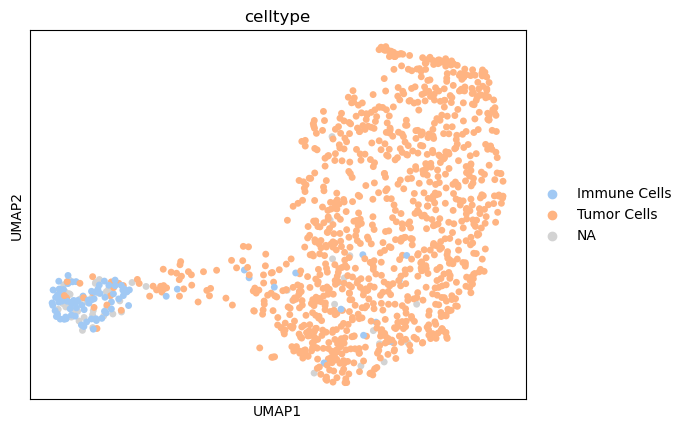

In [14]:
sc.pl.umap(data , color = ["celltype"])

In [15]:
data.obs['celltype'] = data.obs['celltype'].replace("Tumor Cells", "Tumor cells")

In [17]:
data.write("/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core/BTROHT02_7_core_gene_matrix_ANNOTATED_FINAL.h5ad")

In [ ]:
data = sc.read("/BTROHT02_7_core_gene_matrix_ANNOTATED_FINAL.h5ad")

In [ ]:
data.obs['celltype'] = data.obs['celltype'].replace("Tumor Cells", "Tumor cells")

In [7]:
# Define the base directory
BASE_DIR = '/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core'

In [9]:
BASE_DIR

'/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core'

In [8]:
SEED = 42
import numpy as np
import random
import tensorflow as tf

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# CORE


In [9]:
mdata = mu.read_10x_h5("/group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/pre_demultiplexing/BTHROHT01_BTHROHT02_BTHROHT04/multiome/LAZ_315/filtered_feature_bc_matrix.h5")
mdata

/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/pre_demultiplexing/BTHROHT01_BTHROHT02_BTHROHT04/multiome/LAZ_315/filtered_feature_bc_matrix.h5


/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/mudata/_core/mudata.py:477: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from /group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/pre_demultiplexing/BTHROHT01_BTHROHT02_BTHROHT04/multiome/LAZ_315/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/pre_demultiplexing/BTHROHT01_BTHROHT02_BTHROHT04/multiome/LAZ_315/atac_fragments.tsv.gz


[W::hts_idx_load3] The index file is older than the data file: /group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/pre_demultiplexing/BTHROHT01_BTHROHT02_BTHROHT04/multiome/LAZ_315/atac_fragments.tsv.gz.tbi


MuData object with n_obs × n_vars = 4833 × 189167
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	4833 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	4833 x 152566
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

## BTROHT_01

In [10]:
demultiplexing=pd.read_csv('/home/fatemeh.nasrabadi/ROVIGO/multiome/demultiplexing_final.csv', sep='\t')
demultiplexing=demultiplexing.set_index('cell')
demultiplexing

donor_id_rna  prob_max_rna  prob_doublet_rna  \
cell                                                                    
AAACAGCCAGGATAAC-1  BTROHT04_germline      1.000000     6.560000e-231   
AAACAGCCAGGCGAGT-1         unassigned      0.000005      6.650000e-01   
AAACAGCCAGTACCGT-1  BTROHT04_germline      1.000000     3.740000e-254   
AAACATGCACAACAAA-1  BTROHT04_germline      1.000000     2.550000e-107   
AAACATGCACACAATT-1  BTROHT04_germline      1.000000      1.410000e-14   
...                               ...           ...               ...   
TTTGTGGCACTGGCCA-1  BTROHT02_germline      1.000000      6.120000e-15   
TTTGTGGCATGAAGTA-1  BTROHT02_germline      0.999000      5.620000e-04   
TTTGTGTTCGGTTTGG-1  BTROHT02_germline      1.000000      1.940000e-10   
TTTGTTGGTGCTAGAC-1  BTROHT01_germline      1.000000      1.630000e-22   
TTTGTTGGTTGTTGCT-1  BTROHT02_germline      1.000000      0.000000e+00   

                    n_vars_rna   best_singlet_rna  \
cell                                                
AAACAGCCAGGATAAC-1        3708  BTROHT04_germline   
AAACAGCCAGGCGAGT-1          34  BTROHT02_germline   
AAACAGCCAGTACCGT-1        4012  BTROHT04_germline   
AAACATGCACAACAAA-1        1830  BTROHT04_germline   
AAACATGCACACAATT-1         463  BTROHT04_germline   
...                        ...                ...   
TTTGTGGCACTGGCCA-1         325  BTROHT02_germline   
TTTGTGGCATGAAGTA-1          34  BTROHT02_germline   
TTTGTGTTCGGTTTGG-1         367  BTROHT02_germline   
TTTGTTGGTGCTAGAC-1         301  BTROHT01_germline   
TTTGTTGGTTGTTGCT-1       17515  BTROHT02_germline   

                                       best_doublet_rna  \
cell                                                      
AAACAGCCAGGATAAC-1  BTROHT02_germline,BTROHT01_germline   
AAACAGCCAGGCGAGT-1  BTROHT01_germline,BTROHT02_germline   
AAACAGCCAGTACCGT-1  BTROHT02_germline,BTROHT01_germline   
AAACATGCACAACAAA-1  BTROHT02_germline,BTROHT01_germline   
AAACATGCACACAATT-1  BTROHT01_germline,BTROHT04_germline   
...                                                 ...   
TTTGTGGCACTGGCCA-1  BTROHT01_germline,BTROHT02_germline   
TTTGTGGCATGAAGTA-1  BTROHT02_germline,BTROHT01_germline   
TTTGTGTTCGGTTTGG-1  BTROHT02_germline,BTROHT01_germline   
TTTGTTGGTGCTAGAC-1  BTROHT01_germline,BTROHT04_germline   
TTTGTTGGTTGTTGCT-1  BTROHT01_germline,BTROHT02_germline   

                    doublet_logLikRatio_rna      donor_id_atac  prob_max_atac  \
cell                                                                            
AAACAGCCAGGATAAC-1                 -527.035            doublet   0.000000e+00   
AAACAGCCAGGCGAGT-1                   14.838  BTROHT02_germline   1.000000e+00   
AAACAGCCAGTACCGT-1                 -580.559  BTROHT04_germline   1.000000e+00   
AAACATGCACAACAAA-1                 -242.462  BTROHT04_germline   1.000000e+00   
AAACATGCACACAATT-1                  -28.913  BTROHT04_germline   1.000000e+00   
...                                     ...                ...            ...   
TTTGTGGCACTGGCCA-1                  -29.747  BTROHT02_germline   1.000000e+00   
TTTGTGGCATGAAGTA-1                   -4.503  BTROHT02_germline   1.000000e+00   
TTTGTGTTCGGTTTGG-1                  -19.381            doublet   2.360000e-45   
TTTGTTGGTGCTAGAC-1                  -47.186  BTROHT01_germline   1.000000e+00   
TTTGTTGGTTGTTGCT-1                -2248.977  BTROHT02_germline   1.000000e+00   

                    prob_doublet_atac  n_vars_atac  best_singlet_atac  \
cell                                                                    
AAACAGCCAGGATAAC-1       1.000000e+00         5451  BTROHT01_germline   
AAACAGCCAGGCGAGT-1      5.240000e-163         2682  BTROHT02_germline   
AAACAGCCAGTACCGT-1       0.000000e+00        20499  BTROHT04_germline   
AAACATGCACAACAAA-1       0.000000e+00        14025  BTROHT04_germline   
AAACATGCACACAATT-1       0.000000e+00         7291  BTROHT04_germline   
...                               ...          ...  

In [11]:
mdata_core = mdata[mdata.obs_names.isin(demultiplexing[demultiplexing['final_donor_id']=='BTROHT02_germline'].index)]

In [12]:
mdata_core.var

gene_ids    feature_types  genome  \
MIR1302-2HG                    ENSG00000243485  Gene Expression  GRCh38   
FAM138A                        ENSG00000237613  Gene Expression  GRCh38   
OR4F5                          ENSG00000186092  Gene Expression  GRCh38   
AL627309.1                     ENSG00000238009  Gene Expression  GRCh38   
AL627309.3                     ENSG00000239945  Gene Expression  GRCh38   
...                                        ...              ...     ...   
GL000218.1:57745-58512  GL000218.1:57745-58512            Peaks  GRCh38   
KI270711.1:7961-8834      KI270711.1:7961-8834            Peaks  GRCh38   
KI270711.1:9031-9649      KI270711.1:9031-9649            Peaks  GRCh38   
KI270713.1:21428-22328  KI270713.1:21428-22328            Peaks  GRCh38   
KI270713.1:26101-26835  KI270713.1:26101-26835            Peaks  GRCh38   

                                      interval  
MIR1302-2HG                   chr1:29553-30267  
FAM138A                       chr1:36080-36081  
OR4F5                         chr1:65418-69055  
AL627309.1                  chr1:120931-133723  
AL627309.3                    chr1:91104-91105  
...                                        ...  
GL000218.1:57745-58512  GL000218.1:57745-58512  
KI270711.1:7961-8834      KI270711.1:7961-8834  
KI270711.1:9031-9649      KI270711.1:9031-9649  
KI270713.1:21428-22328  KI270713.1:21428-22328  
KI270713.1:26101-26835  KI270713.1:26101-26835  

[189167 rows x 4 columns]

In [13]:
mdata_core.var_names_make_unique()

/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
mdata_core

View of MuData object with n_obs × n_vars = 1888 × 189167
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	1888 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	1888 x 152566
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

In [15]:
rna_core = mdata_core.mod['rna']
rna_core

AnnData object with n_obs × n_vars = 1888 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [16]:
atac = mdata_core.mod['atac'] 
atac

AnnData object with n_obs × n_vars = 1888 × 152566
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

In [17]:
BASE_DIR

'/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core'

## Save Raw ATAC and Raw mdata

In [26]:
atac.write(f'{BASE_DIR}/BTROHT02_1_core_raw_atac.h5ad')

In [19]:
# Save the file
rna_core.write(f'{BASE_DIR}/BTROHT02_2_core_raw_rna.h5ad')

In [20]:
# Save the file
mdata.write(f'{BASE_DIR}/BTROHT02_3_core_mdata_rna_atac.h5ad')

/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/mudata/_core/mudata.py:477: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


## Reading the RNA-data

In [23]:
rna_core = sc.read(f'{BASE_DIR}/BTROHT02_2_core_raw_rna.h5ad')

In [28]:
atac = sc.read(f'{BASE_DIR}/BTROHT02_1_core_raw_atac.h5ad')

## Opening the Count Matrics

In [29]:
rna_core.X

<1888x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 4396367 stored elements in Compressed Sparse Row format>

In [30]:
print(rna_core.X)
rna_core.X.shape

  (0, 59)	1.0
  (0, 777)	1.0
  (0, 2181)	1.0
  (0, 2190)	1.0
  (0, 2520)	1.0
  (0, 2543)	1.0
  (0, 3072)	1.0
  (0, 3523)	1.0
  (0, 3910)	1.0
  (0, 4013)	1.0
  (0, 4100)	1.0
  (0, 4201)	1.0
  (0, 4337)	1.0
  (0, 5005)	1.0
  (0, 5052)	1.0
  (0, 5054)	1.0
  (0, 5674)	1.0
  (0, 5785)	1.0
  (0, 6394)	1.0
  (0, 6402)	1.0
  (0, 6470)	1.0
  (0, 6666)	1.0
  (0, 6781)	1.0
  (0, 6788)	1.0
  (0, 6983)	1.0
  :	:
  (1887, 36470)	1.0
  (1887, 36492)	14.0
  (1887, 36494)	5.0
  (1887, 36495)	29.0
  (1887, 36500)	16.0
  (1887, 36513)	14.0
  (1887, 36515)	2.0
  (1887, 36516)	1.0
  (1887, 36519)	2.0
  (1887, 36559)	2.0
  (1887, 36560)	5.0
  (1887, 36561)	10.0
  (1887, 36562)	10.0
  (1887, 36563)	3.0
  (1887, 36564)	2.0
  (1887, 36565)	9.0
  (1887, 36566)	10.0
  (1887, 36567)	1.0
  (1887, 36568)	7.0
  (1887, 36569)	4.0
  (1887, 36570)	1.0
  (1887, 36571)	3.0
  (1887, 36575)	3.0
  (1887, 36580)	2.0
  (1887, 36581)	1.0


(1888, 36601)

In [31]:
dense_matrix = rna_core.X.toarray()  # Convert to a dense NumPy array
print(dense_matrix)  # Display the entire matrix


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
print(dense_matrix[:45, :500])  # View the first 10 rows and 10 columns

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [33]:
import pandas as pd

# Create a DataFrame with genes as columns and cells as rows
matrix_df = pd.DataFrame(
    dense_matrix, 
    index=rna_core.obs_names,  # Cell IDs
    columns=rna_core.var_names  # Gene names
)

# View the DataFrame
print(matrix_df)


                    MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  \
AAACAGCCAGGCGAGT-1          0.0      0.0    0.0         0.0         0.0   
AAACCGGCATCACAGC-1          0.0      0.0    0.0         0.0         0.0   
AAACGCGCAACATAAG-1          0.0      0.0    0.0         0.0         0.0   
AAACGCGCAAGCTTAT-1          0.0      0.0    0.0         0.0         0.0   
AAACGCGCACCTAATG-1          0.0      0.0    0.0         0.0         0.0   
...                         ...      ...    ...         ...         ...   
TTTGTGAAGTTGTCAA-1          0.0      0.0    0.0         0.0         0.0   
TTTGTGGCACTGGCCA-1          0.0      0.0    0.0         0.0         0.0   
TTTGTGGCATGAAGTA-1          0.0      0.0    0.0         0.0         0.0   
TTTGTGTTCGGTTTGG-1          0.0      0.0    0.0         0.0         0.0   
TTTGTTGGTTGTTGCT-1          0.0      0.0    0.0         0.0         0.0   

                    AL627309.2  AL627309.5  AL627309.4  AP006222.2  \
AAACAGCCAGGCGAGT-1         0.

In [34]:
# Display the column for the gene FAM138A
print(matrix_df["FAM138A"])


AAACAGCCAGGCGAGT-1    0.0
AAACCGGCATCACAGC-1    0.0
AAACGCGCAACATAAG-1    0.0
AAACGCGCAAGCTTAT-1    0.0
AAACGCGCACCTAATG-1    0.0
                     ... 
TTTGTGAAGTTGTCAA-1    0.0
TTTGTGGCACTGGCCA-1    0.0
TTTGTGGCATGAAGTA-1    0.0
TTTGTGTTCGGTTTGG-1    0.0
TTTGTTGGTTGTTGCT-1    0.0
Name: FAM138A, Length: 1888, dtype: float32


## QC 

In [35]:
rna_core.var['mt'] = rna_core.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_core, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

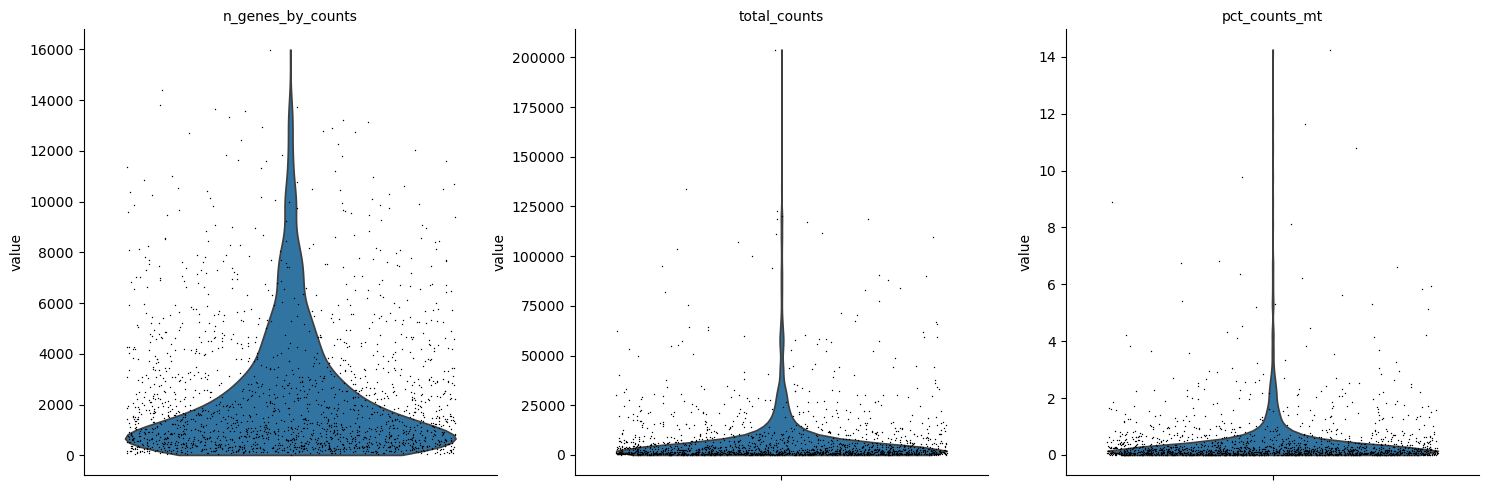

In [36]:
import scanpy as sc
import matplotlib.pyplot as plt

save_path = 'QC_RNA_before_filtration.pdf'
sc.pl.violin(rna_core, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save=save_path)

In [37]:
#Droublet analysis 
#conda install scikit-image=0.24.0 --no-channel-priority
new_core = sc.pp.scrublet(rna_core, adata_sim=None, batch_key=None, sim_doublet_ratio=2.0, expected_doublet_rate=0.05, stdev_doublet_rate=0.02, synthetic_doublet_umi_subsampling=1.0, knn_dist_metric='euclidean', normalize_variance=True, log_transform=False, mean_center=True, n_prin_comps=30, use_approx_neighbors=None, get_doublet_neighbor_parents=False, n_neighbors=None, threshold=None, verbose=True, copy=True, random_state=0)
new_core.obs['predicted_doublet']
percentage_true = (new_core.obs['predicted_doublet'].sum() / len(new_core.obs['predicted_doublet'])) * 100
new_core.obs['predicted_doublet'].sum() 
percentage_true

#if you do not specify a value for the threshold parameter (i.e., you set it to None), Scrublet will automatically determine an appropriate threshold.
#The method used is based on analyzing the distribution of the doublet_scores_sim_ (the simulated doublet scores) histogram.

77.01271186440678

In [38]:
# Count True and False values in 'predicted_doublet'
true_count = new_core.obs['predicted_doublet'].sum()  # Counts True values
false_count = (~new_core.obs['predicted_doublet']).sum()  # Counts False values

print(f"True count: {true_count}")
print(f"False count: {false_count}")


True count: 1454
False count: 434


In [39]:
# Check for unique values in 'predicted_doublet'
unique_values = new_core.obs['predicted_doublet'].unique()

# Display unique values
print("Unique values in 'predicted_doublet':", unique_values)


Unique values in 'predicted_doublet': [False  True]


In [40]:
# Count the total number of entries in 'predicted_doublet'
total_count = new_core.obs['predicted_doublet'].count()

# Count the number of True values in 'predicted_doublet'
true_count = new_core.obs['predicted_doublet'].sum()

# Calculate the proportion of True values
true_proportion = true_count / total_count if total_count > 0 else 0

# Display the results
print(f"Total entries: {total_count}")
print(f"Number of True values: {true_count}")
print(f"Proportion of True values: {true_proportion:.2%}")


Total entries: 1888
Number of True values: 1454
Proportion of True values: 77.01%


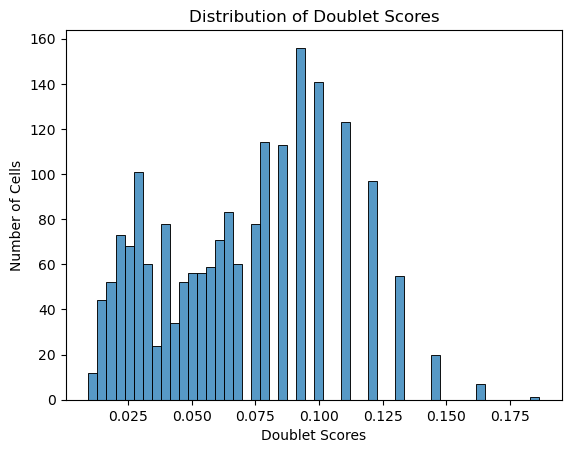

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Access doublet scores
doublet_scores = new_core.obs['doublet_score']

# Plot histogram using seaborn for better aesthetics (or use plt.hist)
sns.histplot(doublet_scores, bins=50, kde=False)
plt.xlabel('Doublet Scores')
plt.ylabel('Number of Cells')
plt.title('Distribution of Doublet Scores')
plt.show()

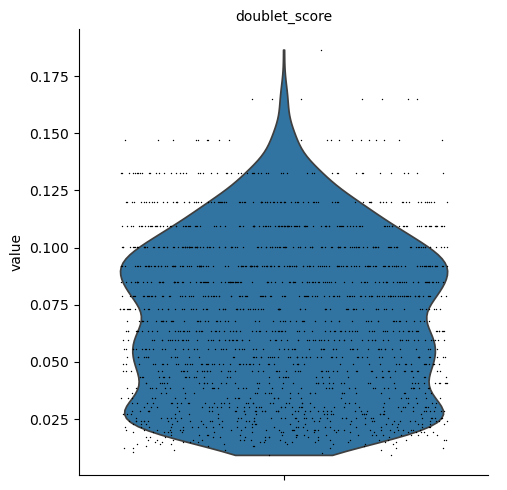

In [42]:
sc.pl.violin(new_core, ['doublet_score'], jitter=0.4, multi_panel=True, save=save_path)

In [43]:
## Filtration 

In [44]:
mu.pp.filter_obs(rna_core, 'n_genes_by_counts', lambda x: (x >= 300))
#The number of genes with at least 1 count in a cell. Calculated for all cells.

In [45]:
mu.pp.filter_obs(rna_core, 'pct_counts_mt', lambda x: x < 5)

In [46]:
rna_core

AnnData object with n_obs × n_vars = 1652 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [47]:
# Initialize the dictionary to store all results
metrics = {}

# QC metrics
metrics["rna_n_genes_by_counts_top"] = None
metrics["rna_n_genes_by_counts_bottom"] = 300
metrics["rna_total_counts_top"] = None
metrics["rna_total_counts_bottom"] = None
metrics["rna_pct_counts_mt"] = 5

# Print QC metrics section
print("QC metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")

# Part 1: RNA Metrics
metrics["rna_core_min_total_counts"] = rna_core.obs['total_counts'].min()
metrics["rna_core_mean_total_counts"] = rna_core.obs['total_counts'].mean()
metrics["rna_core_max_total_counts"] = rna_core.obs['total_counts'].max()

metrics["rna_core_min_n_genes_by_counts"] = rna_core.obs['n_genes_by_counts'].min()
metrics["rna_core_mean_n_genes_by_counts"] = rna_core.obs['n_genes_by_counts'].mean()
metrics["rna_core_max_n_genes_by_counts"] = rna_core.obs['n_genes_by_counts'].max()

# Print RNA Metrics results
print("\nQC Results:")
for key, value in metrics.items():
    if key.startswith("rna_core"):
        print(f"{key}: {value}")

# Part 2: Doublet Analysis
# Count the total number of entries in 'predicted_doublet'
total_count = new_core.obs['predicted_doublet'].count()

# Count the number of True values in 'predicted_doublet'
true_count = new_core.obs['predicted_doublet'].sum()

# Calculate the proportion of True values
true_proportion = true_count / total_count if total_count > 0 else 0

# Add doublet analysis results to metrics
metrics["doublet_total_entries"] = total_count
metrics["doublet_true_count"] = true_count
metrics["doublet_true_proportion"] = f"{true_proportion:.2%}"

# Print doublet analysis results
print("\nDoublet Analysis Results:")
print(f"Total entries in 'predicted_doublet': {total_count}")
print(f"Number of True values: {true_count}")
print(f"Proportion of True values: {true_proportion:.2%}")

# Save the results to a file
file_path = "QC_filtration_metrics.txt"

with open(file_path, 'w') as file:
    # Write QC metrics
    file.write("QC metrics:\n")
    for key, value in metrics.items():
        if key.startswith("rna_") and not key.startswith("rna_core"):
            file.write(f"{key}: {value}\n")
    file.write("\n")
    
    # Write RNA metrics
    file.write("QC Results:\n")
    for key, value in metrics.items():
        if key.startswith("rna_core"):
            file.write(f"{key}: {value}\n")
    file.write("\n")
    
    # Write doublet analysis results
    file.write("Doublet Analysis Results:\n")
    file.write(f"Total entries in 'predicted_doublet': {total_count}\n")
    file.write(f"Number of True values: {true_count}\n")
    file.write(f"Proportion of True values: {true_proportion:.2%}\n")

print(f"Metrics have been written to {file_path}")


QC metrics:
rna_n_genes_by_counts_top: None
rna_n_genes_by_counts_bottom: 300
rna_total_counts_top: None
rna_total_counts_bottom: None
rna_pct_counts_mt: 5

QC Results:
rna_core_min_total_counts: 336.0
rna_core_mean_total_counts: 7919.43994140625
rna_core_max_total_counts: 203879.0
rna_core_min_n_genes_by_counts: 301
rna_core_mean_n_genes_by_counts: 2627.6707021791767
rna_core_max_n_genes_by_counts: 15986

Doublet Analysis Results:
Total entries in 'predicted_doublet': 1888
Number of True values: 1454
Proportion of True values: 77.01%
Metrics have been written to QC_filtration_metrics.txt


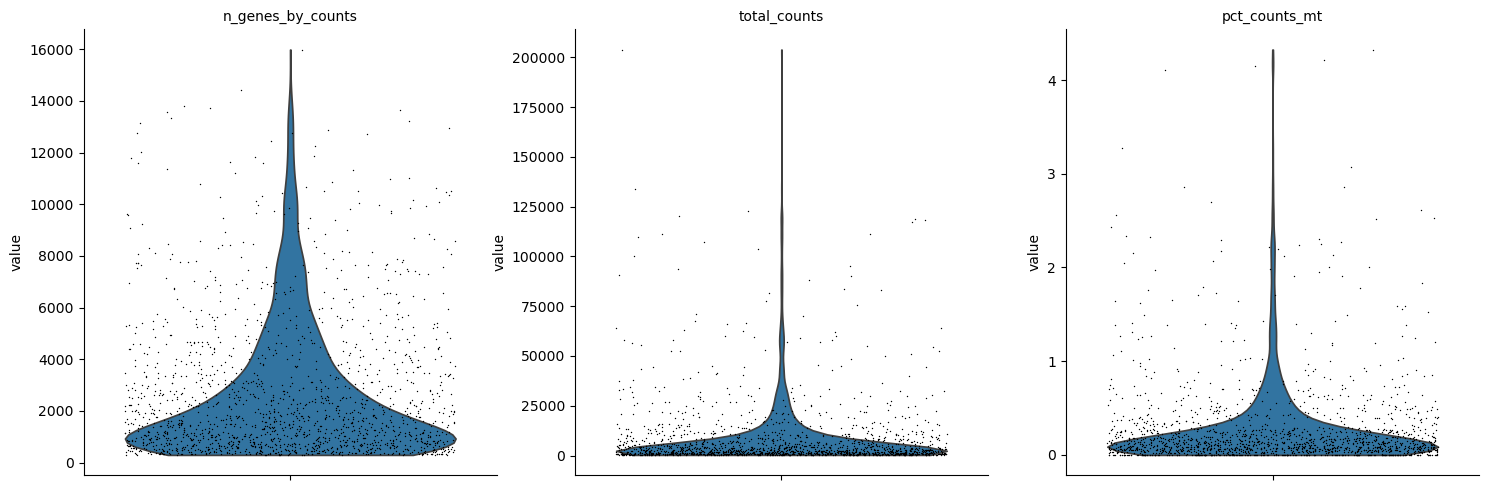

In [48]:
save_path = 'QC_RNA_after_filtration.pdf'
sc.pl.violin(rna_core, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save=save_path)


In [49]:
rna_core

AnnData object with n_obs × n_vars = 1652 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [50]:
rna_core = rna_core[:, ~rna_core.var['mt'].values] #remove mt genes

In [51]:
rna_core

View of AnnData object with n_obs × n_vars = 1652 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [52]:
sc.pp.normalize_total(rna_core, target_sum=1e4)

/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [53]:
sc.pp.log1p(rna_core)

In [54]:
sc.pp.highly_variable_genes(rna_core, min_mean=0.02, max_mean=4, min_disp=0.5)

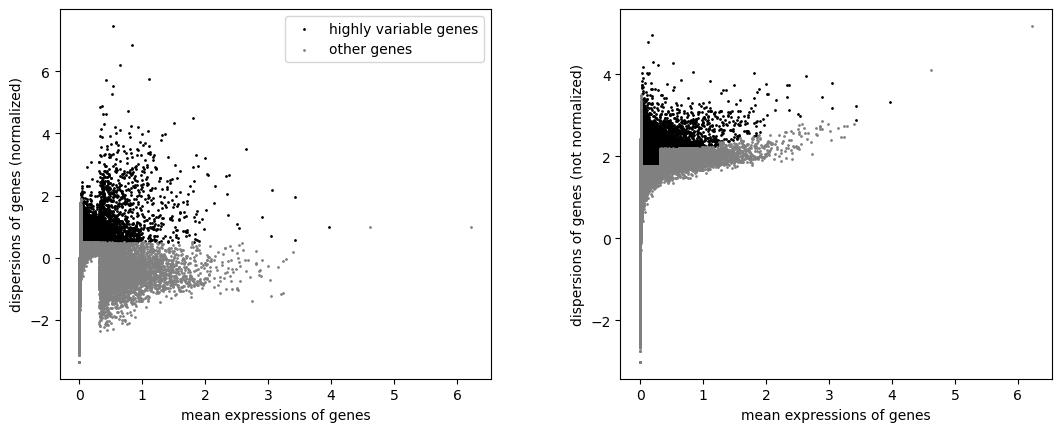

In [55]:
save_path = '.pdf'

sc.pl.highly_variable_genes(rna_core, save=save_path)


In [56]:
rna_core.raw = rna_core #QQQQ
sc.pp.scale(rna_core, max_value=10)

In [57]:
rna_core

AnnData object with n_obs × n_vars = 1652 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [58]:
BASE_DIR

'/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core'

In [59]:
rna_core.write(f'{BASE_DIR}/BTROHT02_4_core_rna_QcFiltered.h5ad')

# Read QC Filtered Data

In [10]:
rna_core = sc.read(f'{BASE_DIR}/BTROHT02_4_core_rna_QcFiltered.h5ad')

In [11]:
rna_core

AnnData object with n_obs × n_vars = 1652 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

## PCA and UMAP 

In [12]:
sc.tl.pca(rna_core, svd_solver='arpack', use_highly_variable=False)

/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


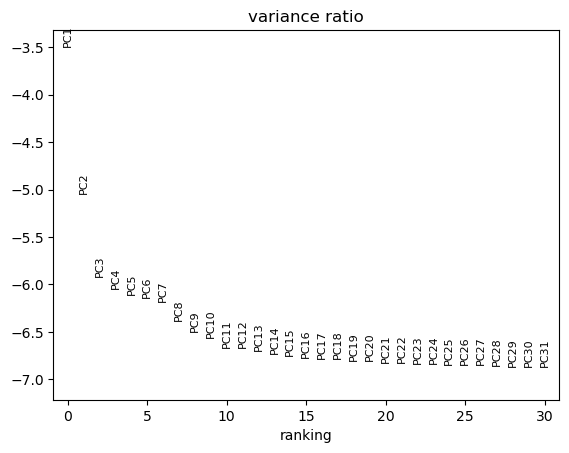

In [13]:
save_path = '.pdf'
sc.pl.pca_variance_ratio(rna_core, log=True, save=save_path)

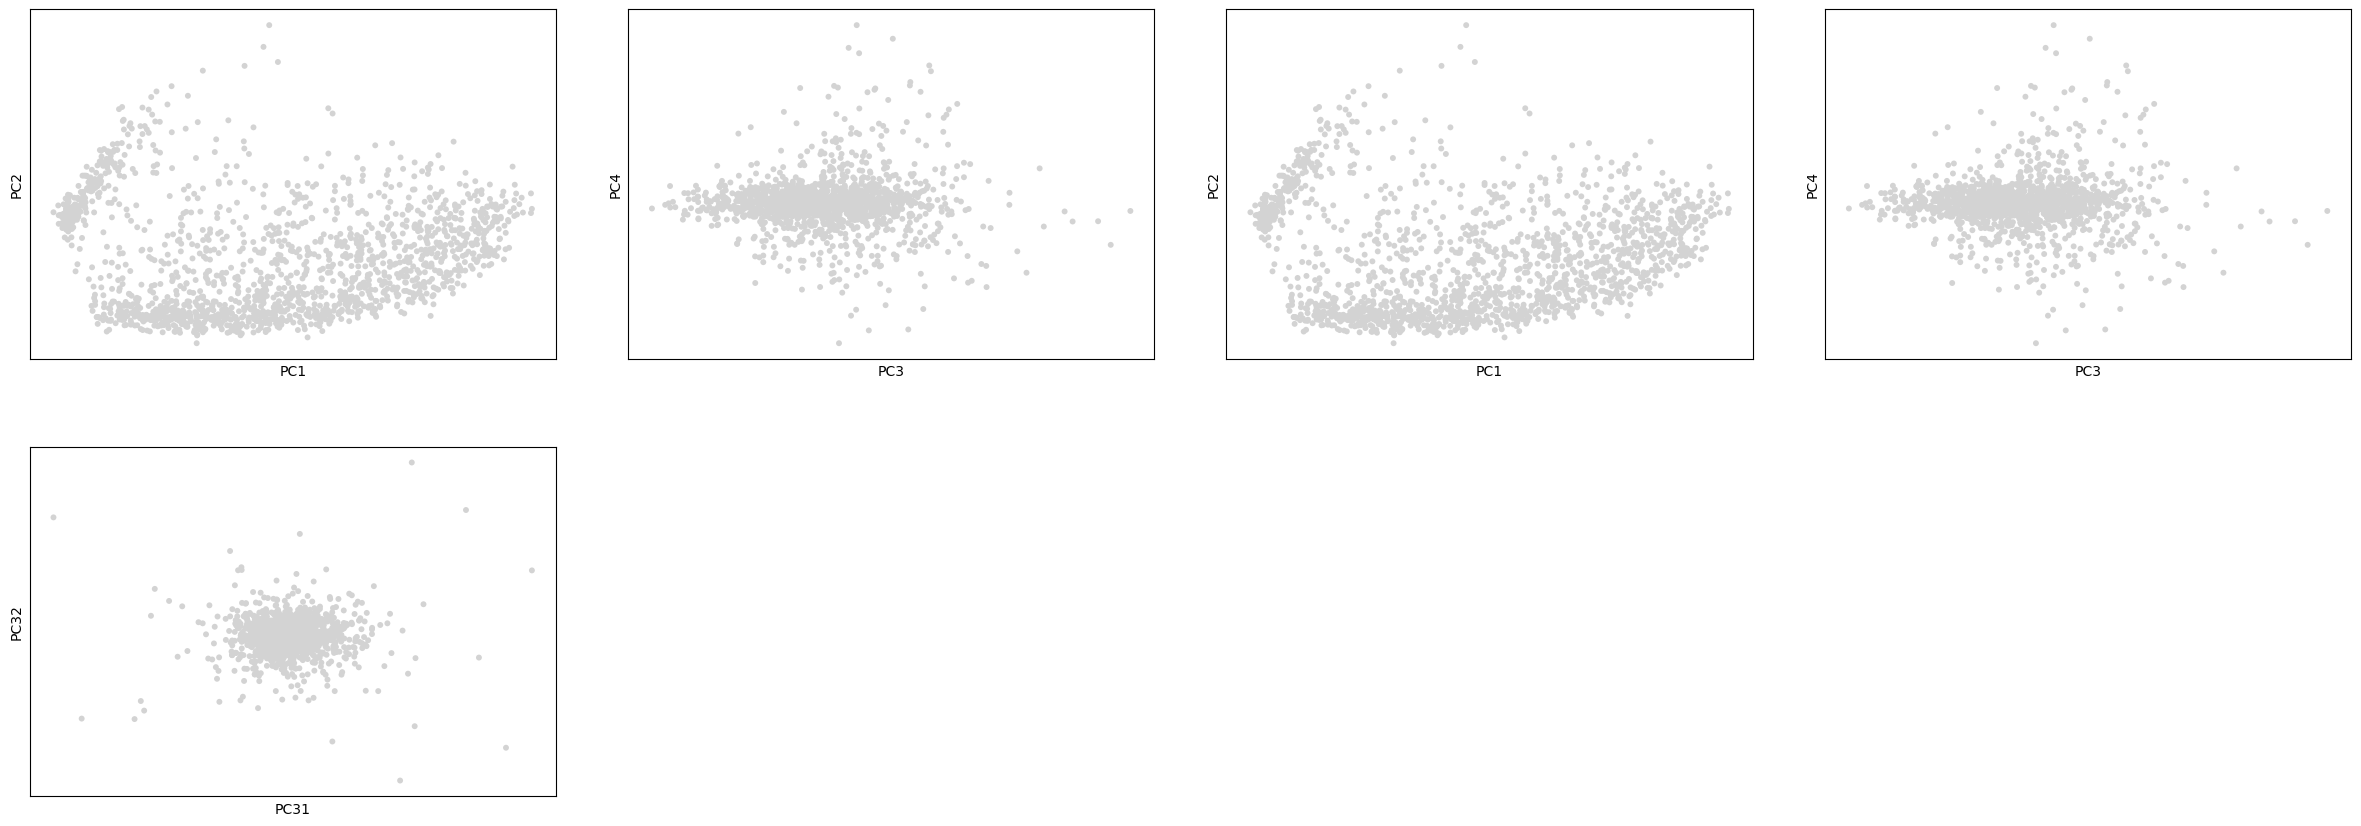

In [14]:
sc.pl.pca(
    rna_core,
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3),(30,31)]
)

In [15]:
# Assuming rna_core is your AnnData object
sc.pp.neighbors(rna_core, n_neighbors=10)  # Calculate neighbors first
sc.tl.umap(rna_core,min_dist=0.15)  # Calculate UMAP

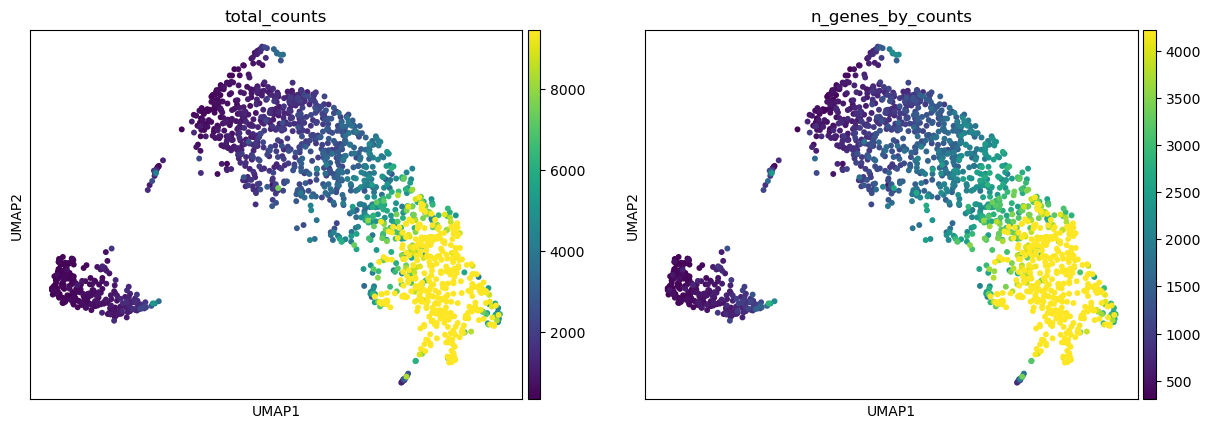

In [16]:
sc.pl.umap(rna_core,color=['total_counts', 'n_genes_by_counts'],vmax='p80') #vmax='p80'

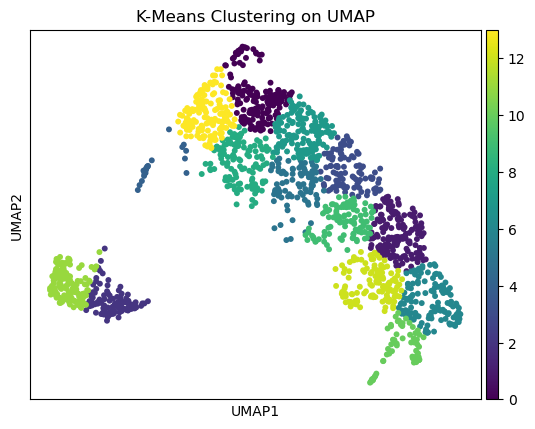

In [17]:
import scanpy as sc
import numpy as np

# Assuming rna_core is your AnnData object
sc.pp.neighbors(rna_core, n_neighbors=10)  # Calculate neighbors first
sc.tl.umap(rna_core,min_dist=0.15)  # Calculate UMAP

# Perform K-Means clustering
from sklearn.cluster import KMeans

# Define the number of clusters (adjust as needed)
num_clusters = 14

# Fit K-Means on the UMAP representation
kmeans = KMeans(n_clusters=num_clusters, random_state=11)
rna_core.obs['kmeans_cluster'] = kmeans.fit_predict(rna_core.obsm['X_umap'])

# Visualize the results
sc.pl.umap(rna_core, color='kmeans_cluster', title='K-Means Clustering on UMAP', legend_loc='on data')

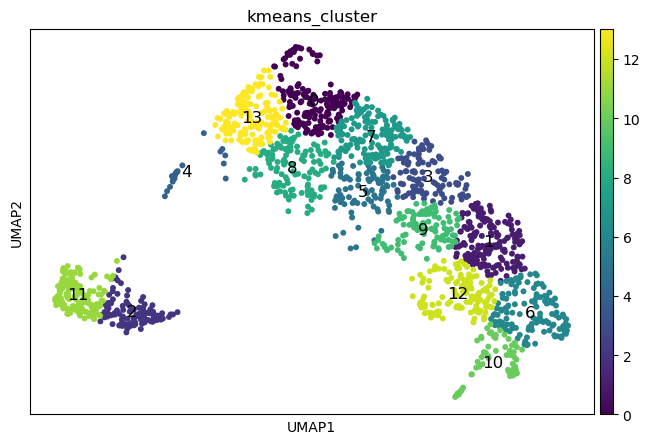

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

# Assume 'rna_core' is your AnnData object

# Create a figure with one plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))  # Adjust the figsize as needed

# Group to plot
group = 'kmeans_cluster'

# Plot the UMAP for the specified group
sc.pl.umap(rna_core, color=group, show=False, ax=ax)

# Add cluster numbers as annotations
for cluster in rna_core.obs[group].unique():
    # Get the UMAP coordinates for the current cluster
    cluster_data = rna_core[rna_core.obs[group] == cluster]
    
    # Calculate the mean UMAP coordinates for the cluster
    mean_x = cluster_data.obsm['X_umap'][:, 0].mean()
    mean_y = cluster_data.obsm['X_umap'][:, 1].mean()
    
    # Add the cluster label at the mean coordinates
    ax.text(mean_x, mean_y, str(cluster), fontsize=12, ha='center', va='center', color='black')

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.7, hspace=0.3)

# Display the plot
plt.show()

# Save the figure
save_path_png = 'figures/UMAP_BTROHT02_Kmeans_clustering_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT02_Kmeans_clustering_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box

# Close the figure to free up memory
plt.close(fig)


In [54]:
sc.tl.leiden(rna_core, resolution=0.1, random_state=11)

In [51]:
#sc.pp.neighbors(rna_core, n_neighbors=10, n_pcs=25, ) #1 #1=10
#sc.pp.neighbors(rna_core, n_neighbors=20, n_pcs=25, ) #0

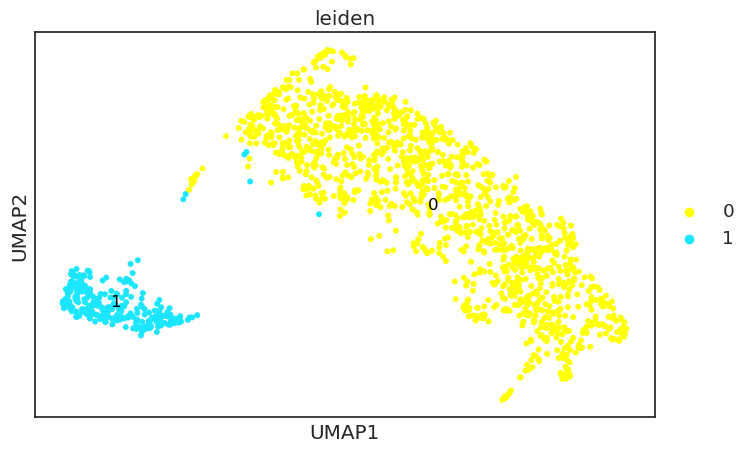

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

# Assume 'rna_core' is your AnnData object

# Create a figure with one plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))  # Adjust the figsize as needed

# Group to plot
group = 'leiden'

# Plot the UMAP for the specified group
sc.pl.umap(rna_core, color=group, show=False, ax=ax)

# Add cluster numbers as annotations
for cluster in rna_core.obs[group].unique():
    # Get the UMAP coordinates for the current cluster
    cluster_data = rna_core[rna_core.obs[group] == cluster]
    
    # Calculate the mean UMAP coordinates for the cluster
    mean_x = cluster_data.obsm['X_umap'][:, 0].mean()
    mean_y = cluster_data.obsm['X_umap'][:, 1].mean()
    
    # Add the cluster label at the mean coordinates
    ax.text(mean_x, mean_y, str(cluster), fontsize=12, ha='center', va='center', color='black')

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.7, hspace=0.3)

# Display the plot
plt.show()

# Save the figure
save_path_png = 'figures/UMAP_BTROHT0-core_leiden_clustering_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT02-core_leiden_clustering_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box

# Close the figure to free up memory
plt.close(fig)


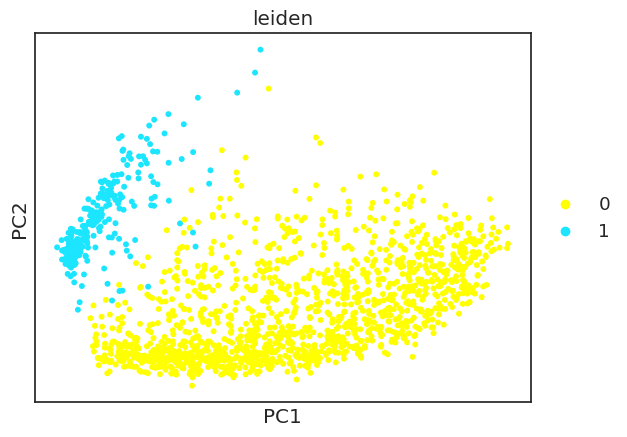

In [56]:
sc.pl.pca(
    rna_core,
    dimensions=[(0, 1)], color='leiden'
)

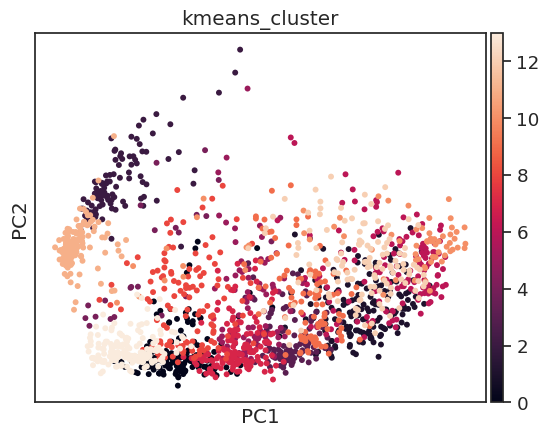

In [57]:
sc.pl.pca(
    rna_core,
    dimensions=[(0, 1)], color='kmeans_cluster'
)

In [58]:
rna_core

AnnData object with n_obs × n_vars = 1652 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'kmeans_cluster', 'leiden', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'celltypist_conf_score_Adult_Human_PrefrontalCortex', 'cnv_raw_l1', 'cnv_raw_l2', 'cnv_score', 'cnv_leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'over_clustering', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex_colors', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex_colors', 'rank_genes_groups', 'cnv_leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


## Celltypist for Core

In [59]:
import celltypist
from celltypist import models
models.models_path= '/home/fatemeh.nasrabadi/ROVIGO/models_cell_typist/'

In [60]:
model = models.Model.load(model = 'Adult_Human_PrefrontalCortex.pkl')
predictions_adultcore = celltypist.annotate(rna_core, model = 'Adult_Human_PrefrontalCortex.pkl', majority_voting = True)

👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will use `.raw.X` instead
🔬 Input data has 1652 cells and 36588 genes
🔗 Matching reference genes in the model
🧬 3652 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [61]:
rna_core.obs['cell_typist_majority_voting_Adult_Human_PrefrontalCortex']=predictions_adultcore.predicted_labels['majority_voting']
rna_core.obs['cell_typist_predicted_labels_Adult_Human_PrefrontalCortex']=predictions_adultcore.predicted_labels['predicted_labels']
rna_core.obs["celltypist_conf_score_Adult_Human_PrefrontalCortex"] = predictions_adultcore.to_adata().obs.loc[
    rna_core.obs.index, "conf_score"
]

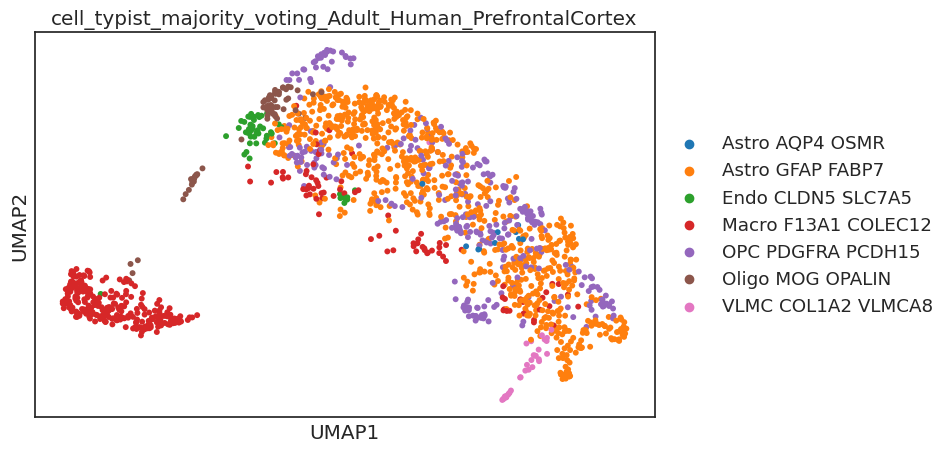

In [62]:
# Assume 'rna_combined' is your AnnData object

# Create a figure with one plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))  # Adjust the figsize as needed

# Group to plot
group = 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex'

# Plot the UMAP for the specified group
sc.pl.umap(rna_core, color=group, show=False, ax=ax)

# Adjust layout and spacing (not really necessary for a single plot, but keeping it in case you expand)
plt.subplots_adjust(wspace=0.7, hspace=0.3)

# Display the plot
plt.show()

# Save the figure
save_path_png = 'figures/UMAP_BTROHT02-core_celltypist_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT02-core_celltypist_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box

# Close the figure to free up memory
plt.close(fig)

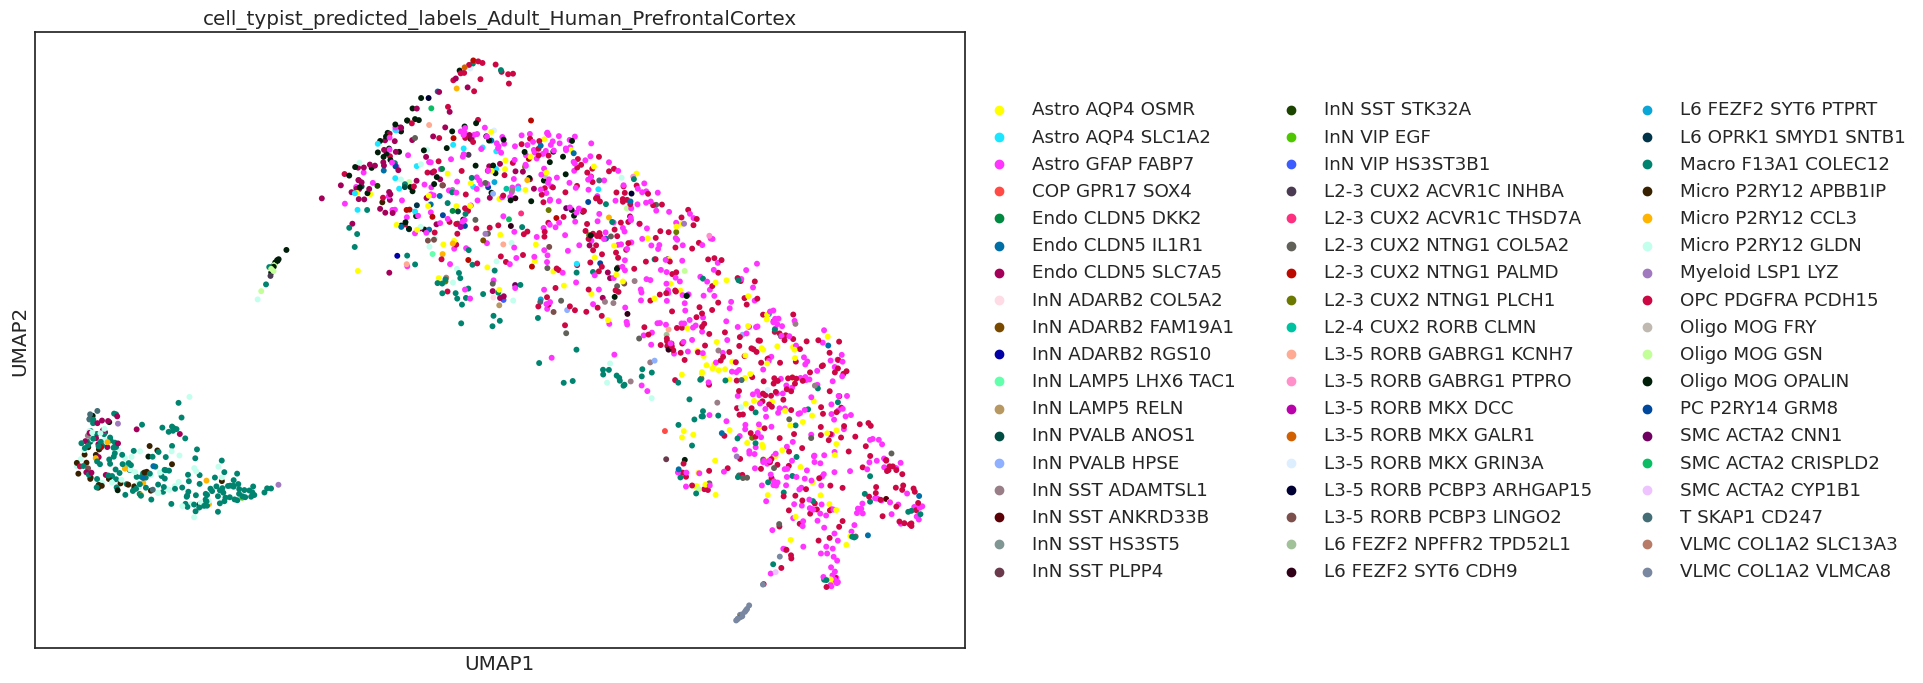

In [63]:
# Assume 'rna_combined' is your AnnData object

# Create a figure with one plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))  # Adjust the figsize as needed

# Group to plot
group = 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex'

# Plot the UMAP for the specified group
sc.pl.umap(rna_core, color=group, show=False, ax=ax)

# Adjust layout and spacing (not really necessary for a single plot, but keeping it in case you expand)
plt.subplots_adjust(wspace=0.7, hspace=0.3)

# Display the plot
plt.show()

# Save the figure
save_path = 'figures/UMAP_BTROHT02-core_celltypist_plots.jpg'
fig.savefig(save_path)

# Close the figure to free up memory
plt.close(fig)


In [73]:
#sc.tl.dendrogram(rna, groupby='celltype',)
sc.tl.rank_genes_groups(rna_core, groupby='cell_typist_majority_voting_Adult_Human_PrefrontalCortex', method='wilcoxon')
 
result = rna_core.uns['rank_genes_groups']
gene_names=[]
gene_dict={}
for type in rna_core.obs['cell_typist_majority_voting_Adult_Human_PrefrontalCortex'].unique():
    if type in result['names'].dtype.names:
        top_genes = result['names'][type][:5]
        gene_names.extend(top_genes)
        gene_dict[type]=top_genes
gene_dict

{'Astro GFAP FABP7': array(['PTPRZ1', 'NLGN1', 'ADGRV1', 'NPAS3', 'PCDH9'], dtype=object),
 'Endo CLDN5 SLC7A5': array(['CLU', 'CAMK2D', 'DNAJB1', 'KMT2E-AS1', 'MYC'], dtype=object),
 'Macro F13A1 COLEC12': array(['PLXDC2', 'DOCK4', 'SLC11A1', 'LRMDA', 'SAT1'], dtype=object),
 'OPC PDGFRA PCDH15': array(['GRIK2', 'LSAMP', 'DPP6', 'THSD7A', 'CDK6'], dtype=object),
 'Oligo MOG OPALIN': array(['MALAT1', 'ST18', 'MBP', 'MAP7', 'CNTNAP4'], dtype=object),
 'VLMC COL1A2 VLMCA8': array(['LAMA2', 'DCN', 'ZEB1', 'COL3A1', 'EPHA3'], dtype=object),
 'Astro AQP4 OSMR': array(['DDX60', 'TAF2', 'RNGTT', 'EFCAB11', 'NPAS3'], dtype=object)}

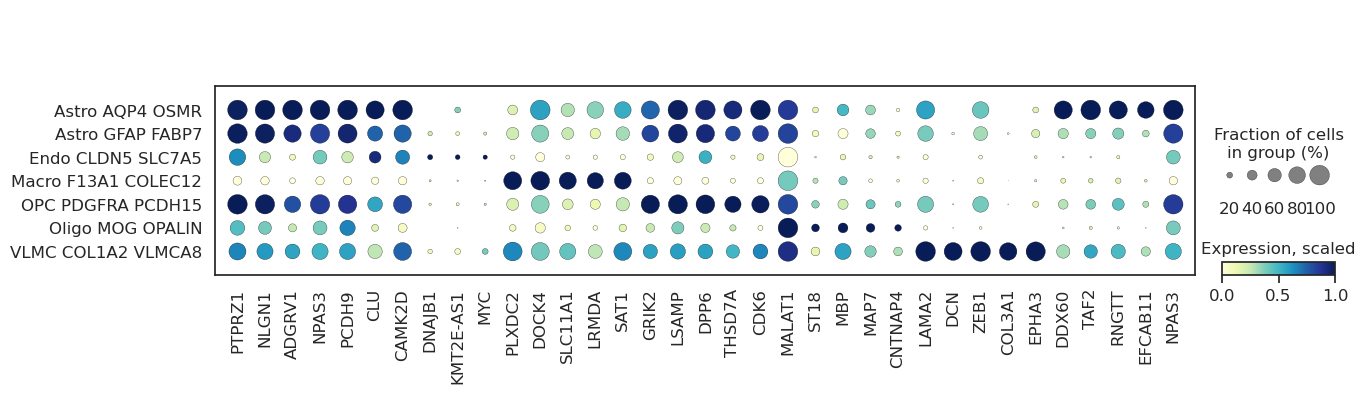

In [74]:
sns.set_theme(style="white", palette="pastel", font_scale = 1.2, rc={"lines.linewidth": 0.5})
save_path='_rna_marker_genes.pdf'

sc.pl.dotplot(rna_core, var_names=gene_names, 
              groupby='cell_typist_majority_voting_Adult_Human_PrefrontalCortex',colorbar_title='Expression, scaled',
              #categories_order=[ 'Brain neurons', 'mOli', 'Microglia'  ,'Astrocytes', 'Tumor cells' ], 
              standard_scale='var', 
              cmap='YlGnBu',  
              
              dendrogram=False,save=save_path)

In [76]:
#sc.tl.dendrogram(rna, groupby='celltype',)
sc.tl.rank_genes_groups(rna_core, groupby='leiden', method='wilcoxon')
 
result = rna_core.uns['rank_genes_groups']
gene_names=[]
gene_dict={}
for type in rna_core.obs['leiden'].unique():
    if type in result['names'].dtype.names:
        top_genes = result['names'][type][:5]
        gene_names.extend(top_genes)
        gene_dict[type]=top_genes
gene_dict

{'0': array(['PTPRZ1', 'NPAS3', 'NLGN1', 'LRP1B', 'NOVA1'], dtype=object),
 '1': array(['DOCK4', 'PLXDC2', 'SLC11A1', 'LRMDA', 'SAT1'], dtype=object)}

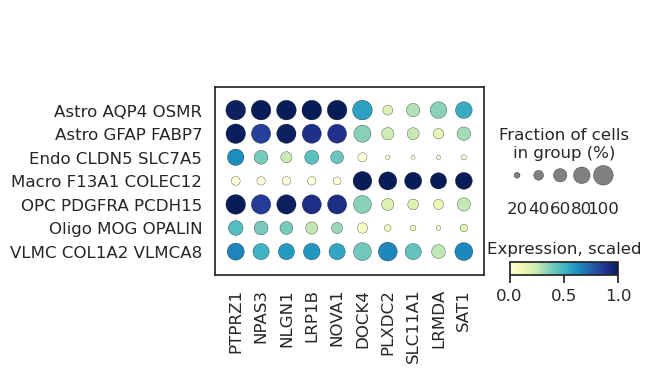

In [77]:
sns.set_theme(style="white", palette="pastel", font_scale = 1.2, rc={"lines.linewidth": 0.5})
save_path='_rna_marker_genes.pdf'

sc.pl.dotplot(rna_core, var_names=gene_names, 
              groupby='cell_typist_majority_voting_Adult_Human_PrefrontalCortex',colorbar_title='Expression, scaled',
              #categories_order=[ 'Brain neurons', 'mOli', 'Microglia'  ,'Astrocytes', 'Tumor cells' ], 
              standard_scale='var', 
              cmap='YlGnBu',  
              
              dendrogram=False,save=save_path)

## InferCNV

In [78]:
import infercnvpy as cnv
adata_add = cnv.datasets.maynard2020_3k()
adata_add.var.loc[:, ["ensg", "chromosome", "start", "end"]]
adata_add

AnnData object with n_obs × n_vars = 3000 × 55556
    obs: 'age', 'sex', 'sample', 'patient', 'cell_type'
    var: 'ensg', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [79]:
adata_add.obs

age     sex  sample    patient        cell_type
Run                                                         
SRR10796381   53  female  LT_S74      TH248       T cell CD4
SRR10787713   40  female  LT_S75      TH266       Macrophage
SRR10785570   56    male  LT_S28      TH185       T cell CD4
SRR10790048   69  female  LT_S65  TH238_NAT         Monocyte
SRR10782528   46  female  LT_S08      TH103  Epithelial cell
...          ...     ...     ...        ...              ...
SRR10782593   71  female  LT_S47      TH220       Fibroblast
SRR10789971   55    male  LT_S21      TH185  Epithelial cell
SRR10780468   62    male  LT_S58      TH179  Epithelial cell
SRR10779840   78  female  LT_S50      TH225              mDC
SRR10795768   63    male  LT_S57      TH226            other

[3000 rows x 5 columns]

In [80]:
adata_add.var

ensg   mito  n_cells_by_counts  mean_counts  \
symbol                                                                 
AL645933.5  ENSG00000288587.1  False               1854     1.613897   
AC010184.1  ENSG00000288585.1  False                310     0.412183   
AC023296.1  ENSG00000288580.1  False                103     0.196091   
AL117334.2  ENSG00000288577.1  False                176     0.087959   
AC107294.4  ENSG00000288576.1  False                  9     0.023121   
...                       ...    ...                ...          ...   
DOCK8-AS1   ENSG00000183784.7  False               1758     9.321348   
LIF-AS1     ENSG00000232530.1  False                265     0.545650   
AC093673.1  ENSG00000232533.1  False               3423    15.522471   
LINC00945   ENSG00000232539.1  False                 10     0.030850   
RPL36P19    ENSG00000232540.1  False                 12     0.008548   

            pct_dropout_by_counts   total_counts       n_counts chromosome  \
symbol                                                                       
AL645933.5              91.340091   34551.914062   34551.914062       chr6   
AC010184.1              98.552011    8824.419922    8824.419922       chr3   
AC023296.1              99.518894    4198.104004    4198.104004       chr8   
AL117334.2              99.177916    1883.123047    1883.123047      chr20   
AC107294.4              99.957962     495.000000     495.000000       chr3   
...                           ...            ...            ...        ...   
DOCK8-AS1               91.788500  199560.750000  199560.750000       chr9   
LIF-AS1                 98.762203   11681.813477   11681.813477      chr22   
AC093673.1              84.011397  332320.593750  332320.593750       chr7   
LINC00945               99.953291     660.473999     660.473999      chr21   
RPL36P19                99.943949     183.000000     183.000000      chr13   

                start        end            gene_id   gene_name  
symbol                                                           
AL645933.5   31400702   31463705  ENSG00000288587.1  AL645933.5  
AC010184.1  141449745  141456434  ENSG00000288585.1  AC010184.1  
AC023296.1    2923568    2926689  ENSG00000288580.1  AC023296.1  
AL117334.2    3406380    3410036  ENSG00000288577.1  AL117334.2  
AC107294.4  184778723  184780720  ENSG00000288576.1  AC107294.4  
...               ...        ...                ...         ...  
DOCK8-AS1      212824     215893  ENSG00000183784.7   DOCK8-AS1  
LIF-AS1      30239194   30240538  ENSG00000232530.1     LIF-AS1  
AC093673.1  143379692  143380495  ENSG00000232533.1  AC093673.1  
LINC00945    33057829   33064983  ENSG00000232539.1   LINC00945  
RPL36P19     43394525   43394825  ENSG00000232540.1    RPL36P19  

[55556 rows x 12 columns]

In [81]:
adata_inf=rna_core.raw.to_adata()
adata_inf.var['end']=adata_add.var.loc[:, ["end"]]
adata_inf.var['start']=adata_add.var.loc[:, ["start"]]
adata_inf.var['chromosome']=adata_add.var.loc[:, ["chromosome"]]
adata_inf.var.loc[:, [ "chromosome", "start", "end"]]

chromosome      start        end
MIR1302-2HG        chr1    29554.0    31109.0
FAM138A            chr1    34554.0    36081.0
OR4F5              chr1    65419.0    71585.0
AL627309.1         chr1    89295.0   133723.0
AL627309.3         chr1    89551.0    91105.0
...                 ...        ...        ...
AC141272.1   KI270728.1  1270984.0  1271271.0
AC023491.2   KI270731.1    10598.0    13001.0
AC007325.1   KI270734.1    72411.0    74814.0
AC007325.4   KI270734.1   131494.0   137392.0
AC007325.2   KI270734.1   138082.0   161852.0

[36588 rows x 3 columns]

In [82]:
rna_core.obs['cell_typist_majority_voting_Adult_Human_PrefrontalCortex'].value_counts()

cell_typist_majority_voting_Adult_Human_PrefrontalCortex
Astro GFAP FABP7       828
Macro F13A1 COLEC12    340
OPC PDGFRA PCDH15      318
Oligo MOG OPALIN        68
Endo CLDN5 SLC7A5       53
VLMC COL1A2 VLMCA8      35
Astro AQP4 OSMR         10
Name: count, dtype: int64

In [83]:
rna_core

AnnData object with n_obs × n_vars = 1652 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'kmeans_cluster', 'leiden', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex', 'predicted_labels', 'majority_voting', 'conf_score', 'celltypist_conf_score_Adult_Human_PrefrontalCortex', 'cnv_raw_l1', 'cnv_raw_l2', 'cnv_score', 'cnv_leiden', 'over_clustering'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'over_clustering', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex_colors', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex_colors', 'rank_genes_groups', 'cnv_leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


In [85]:
cnv.tl.infercnv(
    adata_inf,
    reference_key="leiden",
    window_size=250,
    reference_cat=[
    "1"
    ]
)

  0%|          | 0/1 [00:00<?, ?it/s]

#11, 0 , 9 'kmeans_cluster'

cnv.tl.infercnv(
    adata_inf,
    reference_key='kmeans_cluster',
    window_size=250,
    reference_cat=[
       11,0,9
    ]
)


In [86]:
#######CHECK THE PARAMETERS######### 

In [87]:
cnv.tl.pca(adata_inf)
cnv.pp.neighbors(adata_inf, )
cnv.tl.leiden(adata_inf,resolution=1)
#cnv.tl.leiden(adata_inf,) #0
#resolution=2

for core 

sc.pp.neighbors(rna_core, n_neighbors=20, n_pcs=25, )
sc.tl.umap(rna_core, random_state=11) #default for min_dist=0.5

to : 
    
sc.pp.neighbors(rna_core, n_neighbors=10, n_pcs=25, )
sc.tl.umap(rna_core, random_state=11,min_dist=0.15)


In [88]:
cnv.tl.umap(adata_inf)
cnv.tl.cnv_score(adata_inf)

In [89]:
#два способа расчета cnv score для отдельной клетки
rna_core.obs['cnv_raw_l1'] = pd.DataFrame(np.ravel(np.mean(np.abs(adata_inf.obsm[f"X_cnv"]), axis=1)), 
                                     index=rna_core.obs.index)
rna_core.obs['cnv_raw_l2'] = pd.DataFrame(np.ravel(np.mean((adata_inf.obsm[f"X_cnv"]).power(2), axis=1))**.5, 
                                     index=rna_core.obs.index)
rna_core.obs['cnv_score']=adata_inf.obs['cnv_score']
rna_core.obs['cnv_leiden']=adata_inf.obs['cnv_leiden']

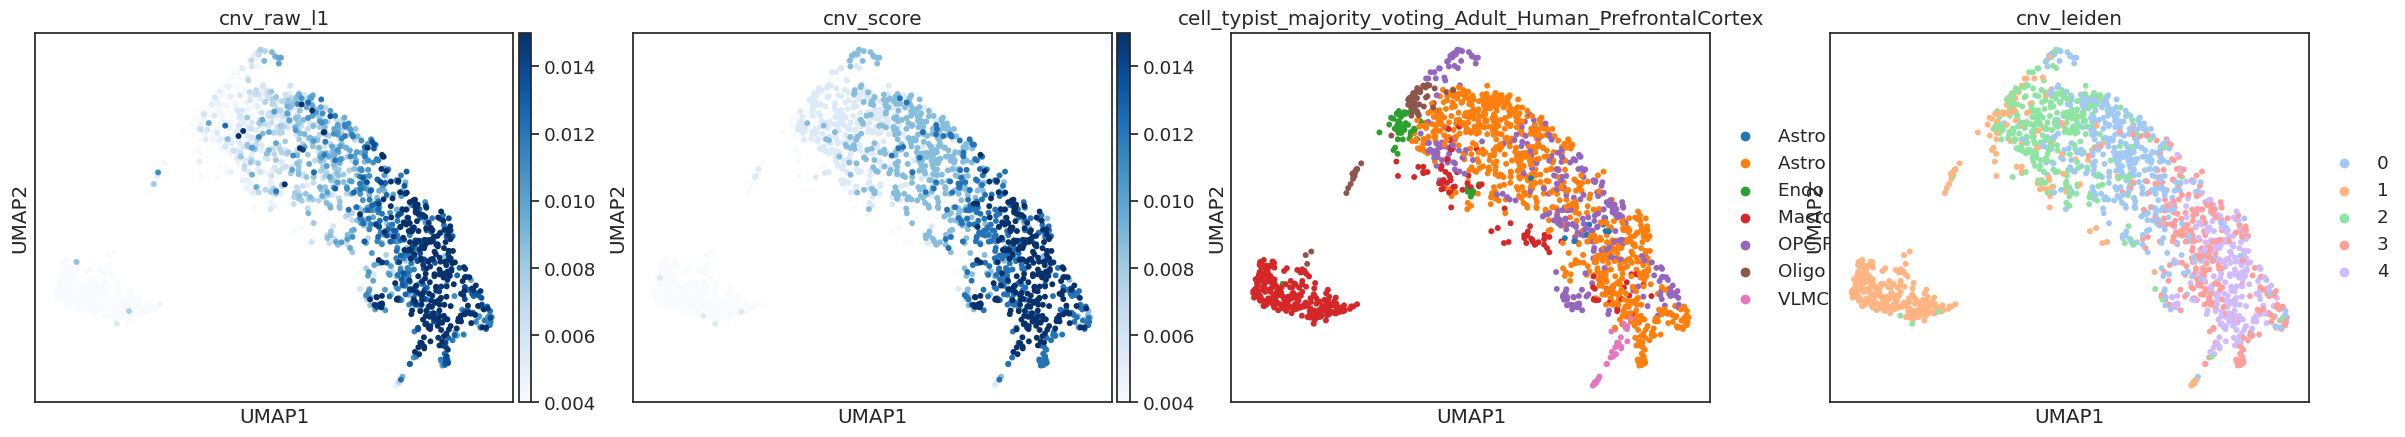

In [90]:
save_path='_rna_cnv.pdf'

sc.pl.umap(rna_core, ncols=4, color=['cnv_raw_l1', 'cnv_score', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex', 'cnv_leiden'], 
            color_map='Blues', vmax=0.015, vmin=0.004, save=save_path)

... storing 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex' as categorical


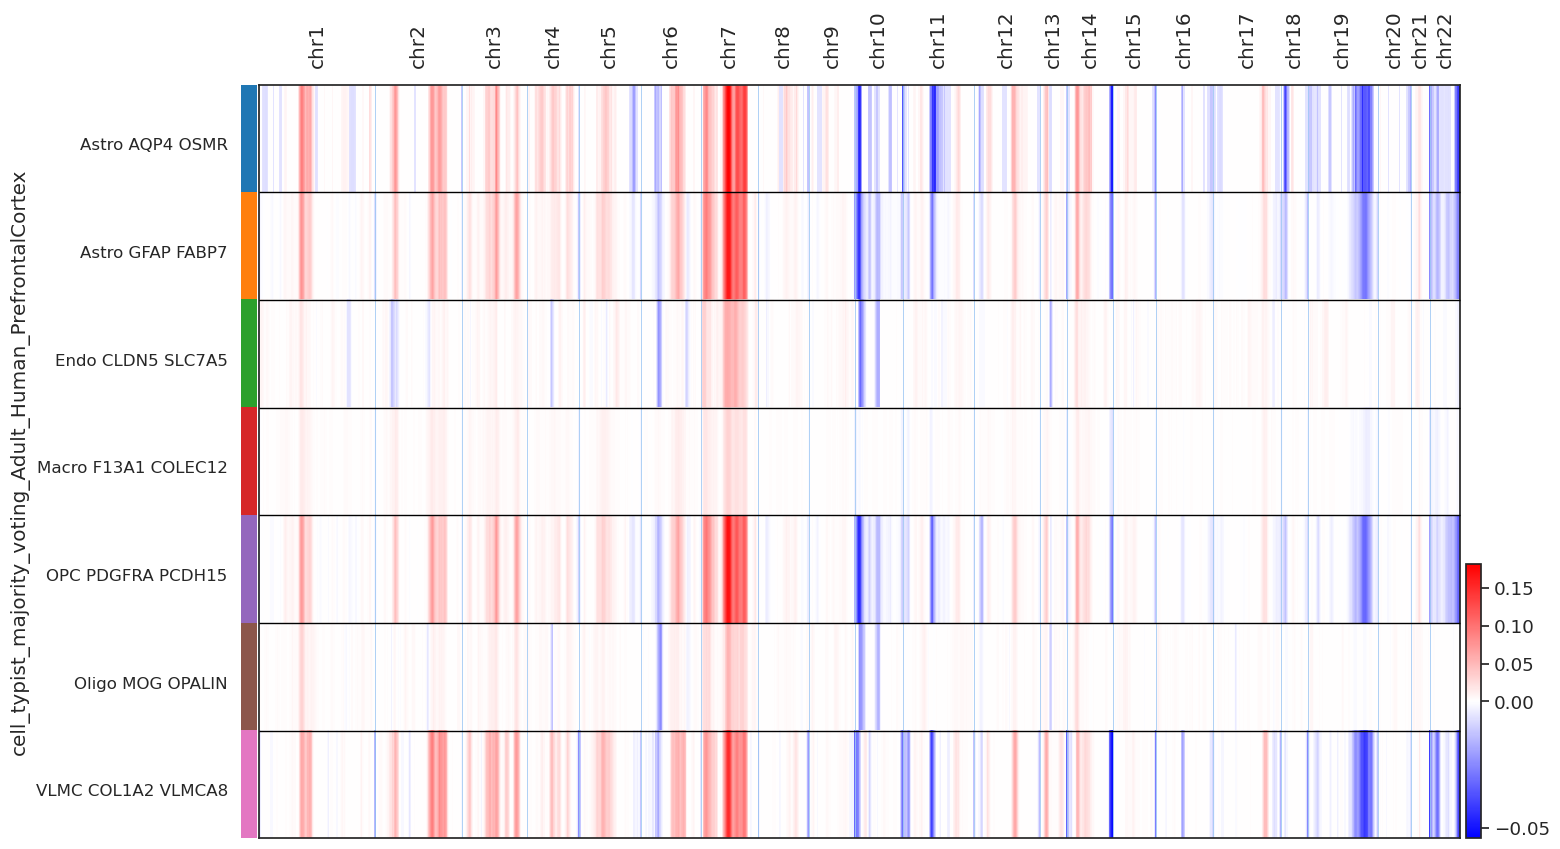

In [91]:

save_path = '_rna_cnv_heatmap_celltypist.pdf'
fig.savefig(save_path)

cnv.pl.chromosome_heatmap_summary(adata_inf, groupby="cell_typist_majority_voting_Adult_Human_PrefrontalCortex", save=save_path)

... storing 'leiden' as categorical


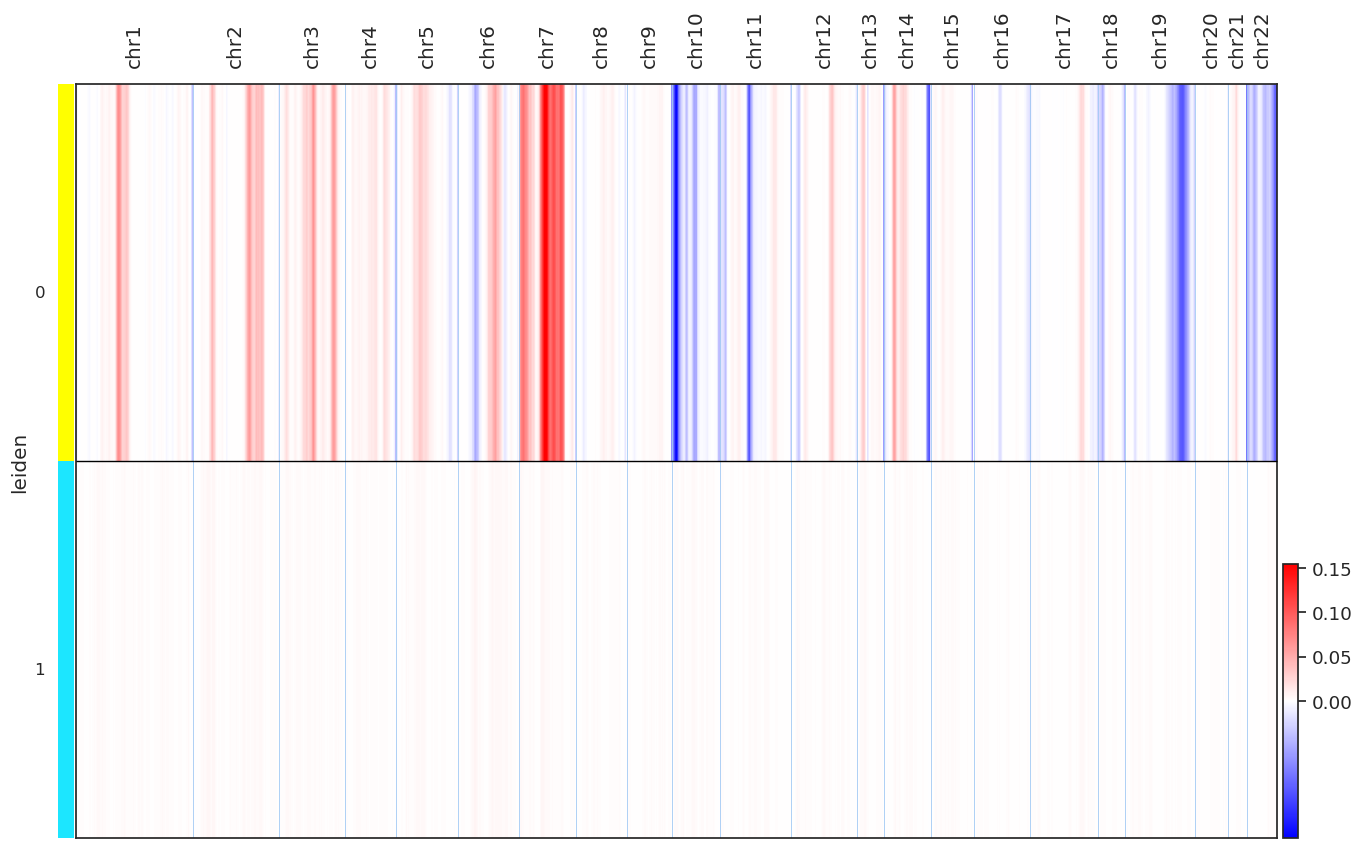

In [92]:
save_path = '_rna_cnv_heatmap_leiden.pdf'
fig.savefig(save_path)

cnv.pl.chromosome_heatmap_summary(adata_inf, groupby="leiden", save=save_path)

... storing 'cnv_leiden' as categorical


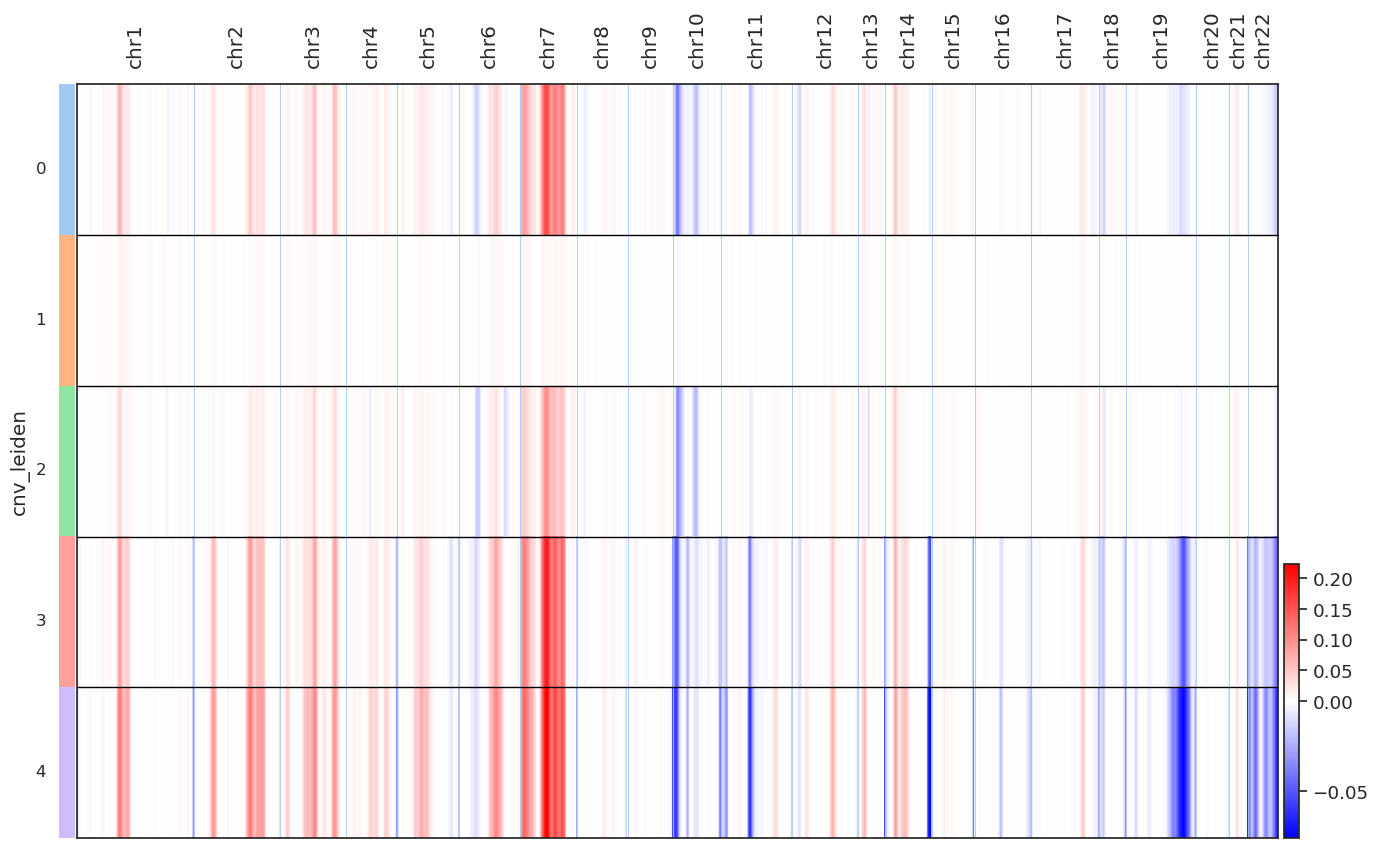

In [93]:
save_path='_rna_cnv_heatmap_cnv_leiden.pdf'
cnv.pl.chromosome_heatmap_summary(adata_inf, groupby="cnv_leiden", save=save_path)

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1
var_group_labels: chr1, chr2, chr3, etc.


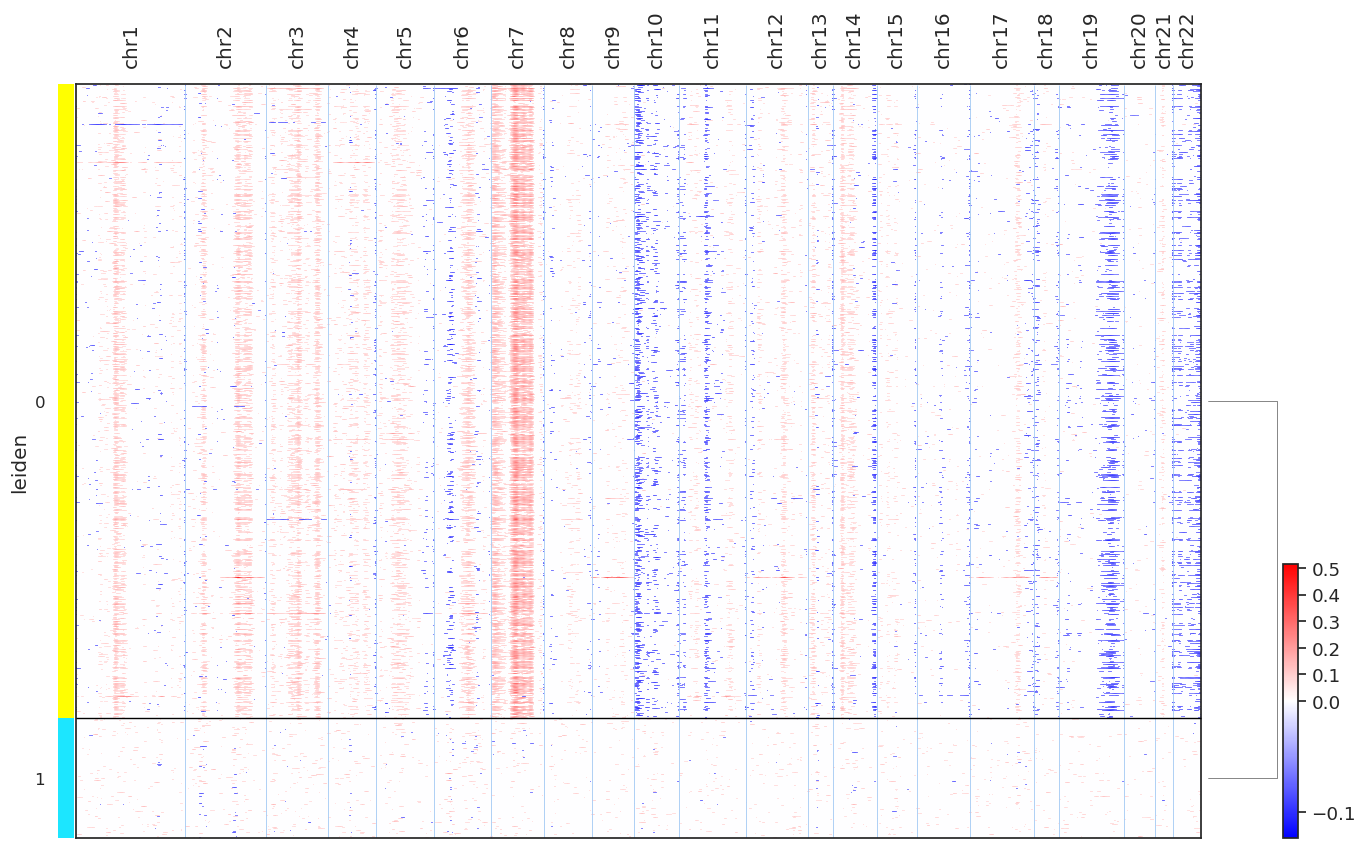

In [94]:
cnv.pl.chromosome_heatmap(adata_inf, groupby="leiden", dendrogram=True)

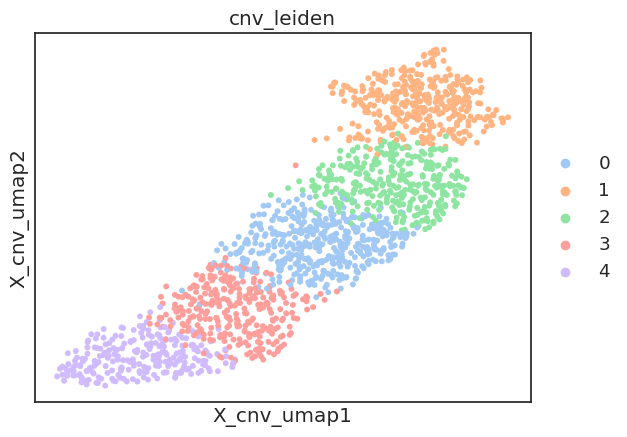

In [95]:
sc.pl.embedding(adata_inf, basis='X_cnv_umap', color=['cnv_leiden'])


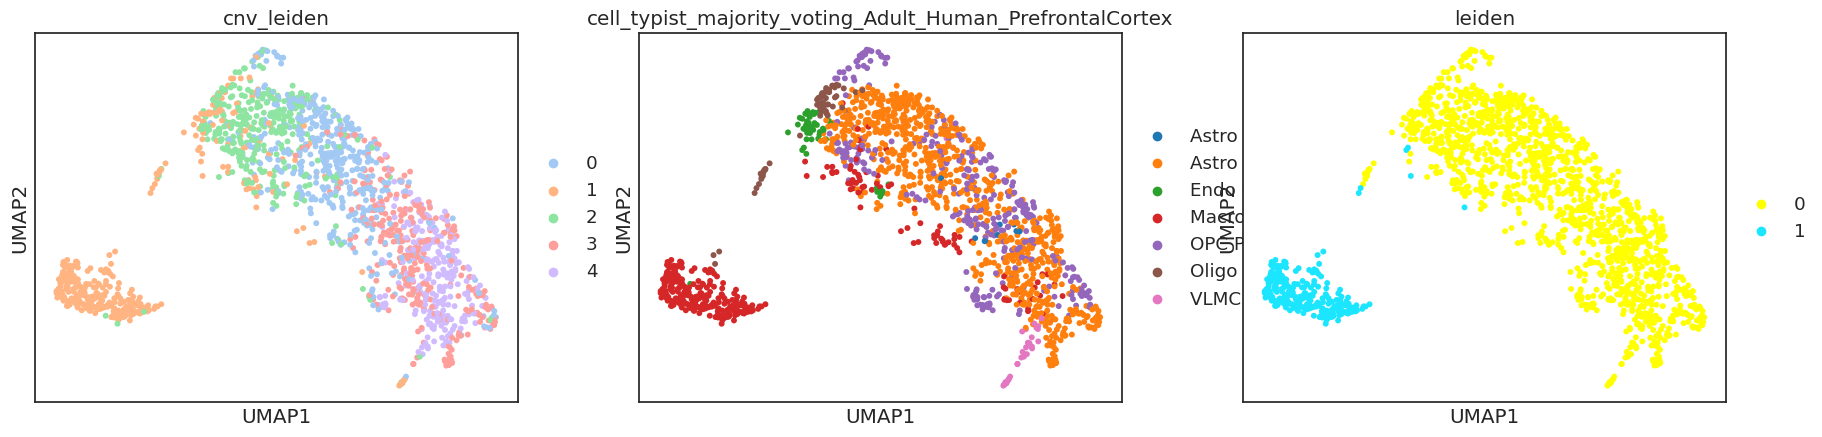

In [96]:
sc.pl.umap(adata_inf, color=['cnv_leiden', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex','leiden'], vmax=20000)

In [100]:
# Map the existing cell type labels to new, more descriptive labels
rna_core.obs['celltype'] = rna_core.obs['leiden'].map({
    '0': 'Tumor Cells',
    '1': 'Immune Cells',
})


rna_core.obs['celltype_new_label'] = rna_core.obs['leiden'].map({
    '14': 'Immune cells',
    '0': 'Immune cells',
    '7': 'Immune cells'
}).fillna('Tumor Cells')


#(Microglia, Macrophages)

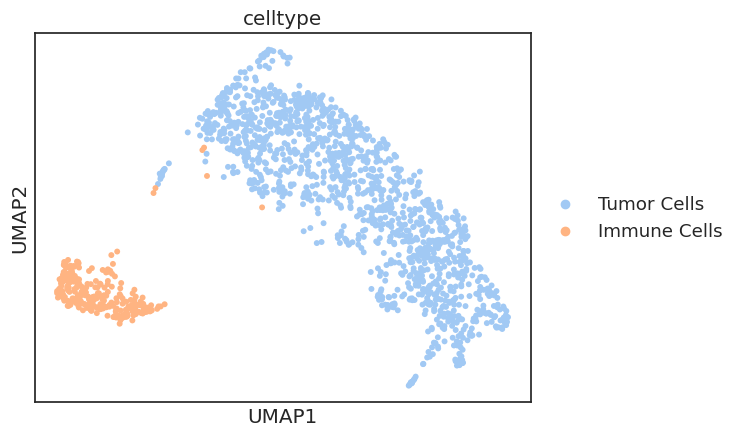

In [101]:
sc.pl.umap(rna_core, color=[ 'celltype'], vmax=20000)

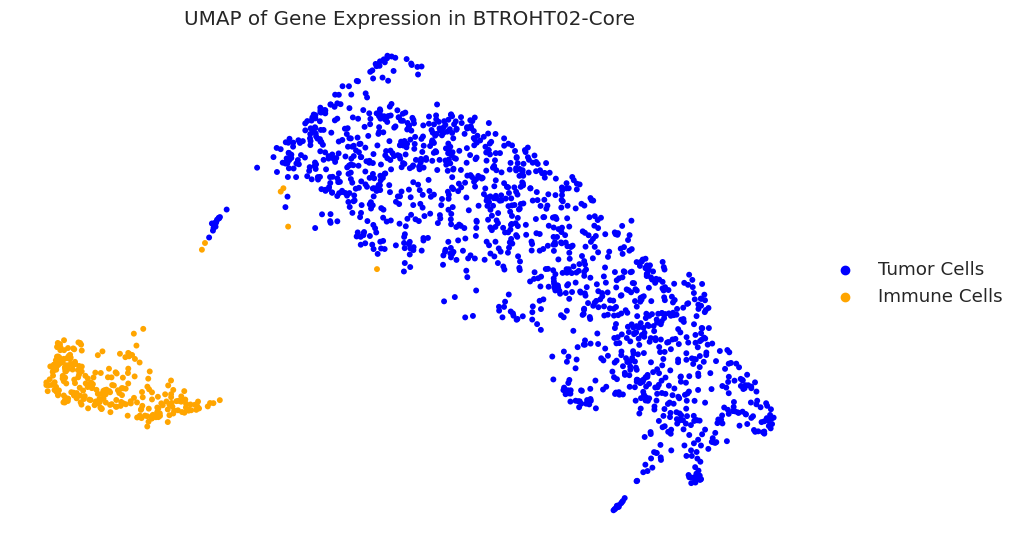

In [105]:
import scanpy as sc
import matplotlib.pyplot as plt

# Assuming `rna_core` is your AnnData object
# Define the color mapping for tumor and immune cells
colors = ['blue' if 'tumor' in cell_type.lower() else 'orange' if 'immune' in cell_type.lower() else 'gray' 
          for cell_type in rna_core.obs['celltype'].unique()]

# Create a color mapping dictionary to associate cell types with their respective colors
color_mapping = dict(zip(rna_core.obs['celltype'].unique(), colors))

# Create the UMAP plot
fig, ax = plt.subplots(figsize=(8, 5))  # Adjust the figsize as needed
sc.pl.umap(
    rna_core, 
    color='celltype', 
    vmax=20000, 
    palette=color_mapping,
    title='UMAP of Gene Expression in BTROHT02-Core',
    show=False,  # Avoid automatic display with a box around
    ax=ax
)


# Adjust layout to remove the box
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.axis('off')  # Hide the axis to avoid a box around the plot


# Save the figure
save_path_png = 'figures/UMAP_BTROHT02-core_leiden_annotated_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT02-core_leiden_annotated_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box



# Display the plot
plt.show()


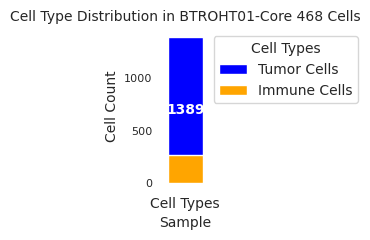

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `rna_core` is your AnnData object
celltype_counts = rna_core.obs['celltype'].value_counts()

# Define colors for each cell type
colors = []
for cell_type in celltype_counts.index:
    if "tumor" in cell_type.lower():
        colors.append("blue")
    elif "immune" in cell_type.lower():
        colors.append("orange")
    else:
        colors.append("gray")  # Use gray for any other cell types

# Plotting
plt.figure(figsize=(0.5, 2))
bars = plt.bar(
    x=['Cell Types'], 
    height=celltype_counts.values, 
    color=colors,
    label=celltype_counts.index
)

# Add labels and title with consistent font sizes
plt.xlabel("Sample", fontsize=10)
plt.ylabel("Cell Count", fontsize=10)
plt.title("Cell Type Distribution in BTROHT01-Core 468 Cells", fontsize=10)

# Add the number of tumor cells behind the bar (inside the bar)
tumor_cells = celltype_counts.get('Tumor Cells', 0)  # Ensure it handles missing data gracefully
plt.text(0, tumor_cells / 2, str(tumor_cells), ha='center', va='center', fontsize=10, color='white', weight='bold')

# Set legend with color references for each cell type
plt.legend(celltype_counts.index, title="Cell Types", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=10)

# Adjust y-axis tick labels
plt.yticks(fontsize=8)  # Adjusted y-tick font size

# Ensure consistent font size for all text
plt.xticks(fontsize=10)  # Match x-tick font size to others

# Remove the box around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Save the figure
save_path_png = 'figures/UMAP_BTROHT02-core_barplot_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT02-core_barplot_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box


plt.show()


... storing 'CNV Inference' as categorical


Unique cell types: ['Tumor Cells', 'Immune Cells']
Categories (2, object): ['Tumor Cells', 'Immune Cells']


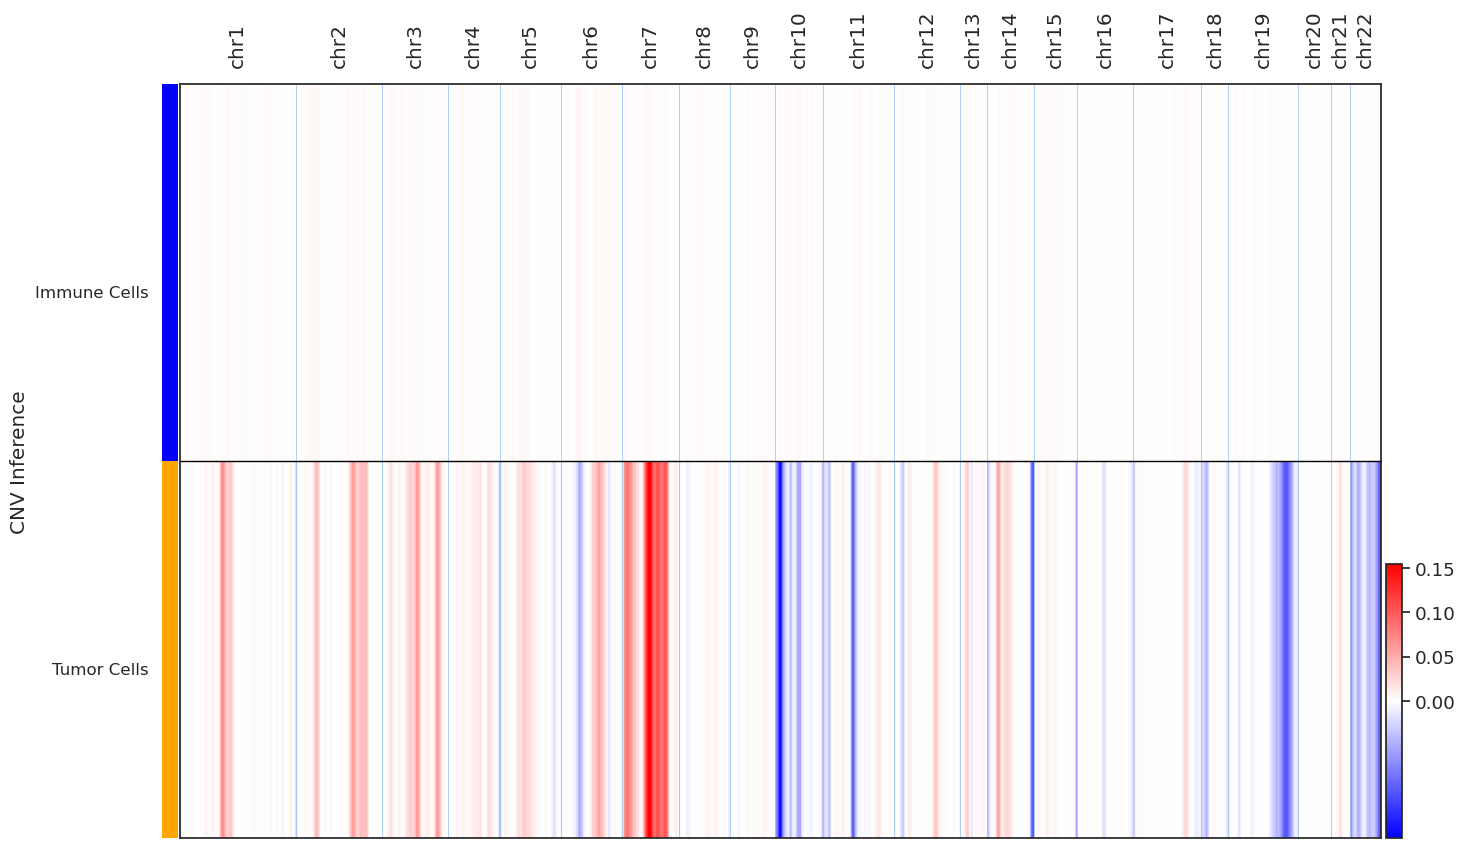

In [107]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

# Step 1: Define the custom color mapping
custom_colors = {
    'Immune Cells': 'Orange',  # Orange for immune cells
    'Tumor Cells': '#0000FF'   # Blue for tumor cells
}
default_color = '#808080'  # Grey for unspecified cell types

# Step 2: Map colors to the cell types
adata_inf.obs['CNV Inference'] = rna_core.obs['celltype']

# Step 3: Inspect unique cell types (optional for debugging)
print("Unique cell types:", adata_inf.obs['CNV Inference'].unique())

# Step 4: Update the CNV Inference palette in the AnnData object
adata_inf.uns['CNV Inference_colors'] = [
    to_hex(custom_colors.get(celltype, default_color)) for celltype in adata_inf.obs['CNV Inference'].unique()
]

# Step 5: Plot the heatmap and save the figure
save_path = '_rna_cnv_heatmap_celltype.pdf'
cnv.pl.chromosome_heatmap_summary(adata_inf, groupby="CNV Inference", save=save_path)

# Save the figure
save_path_png = 'figures/UMAP_BTROHT02-core_CNV_annotated_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT02-core_CNV_annotated_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box

plt.show()


## Cell cycle Analysis

In [108]:
cell_cycle_genes = [x.strip() for x in open('/home/fatemeh.nasrabadi/files/cellcycle/regev_lab_cell_cycle_genes.txt')]

In [109]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in rna_core.var_names]

In [110]:
sc.tl.score_genes_cell_cycle(rna_core, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=False)

... storing 'phase' as categorical


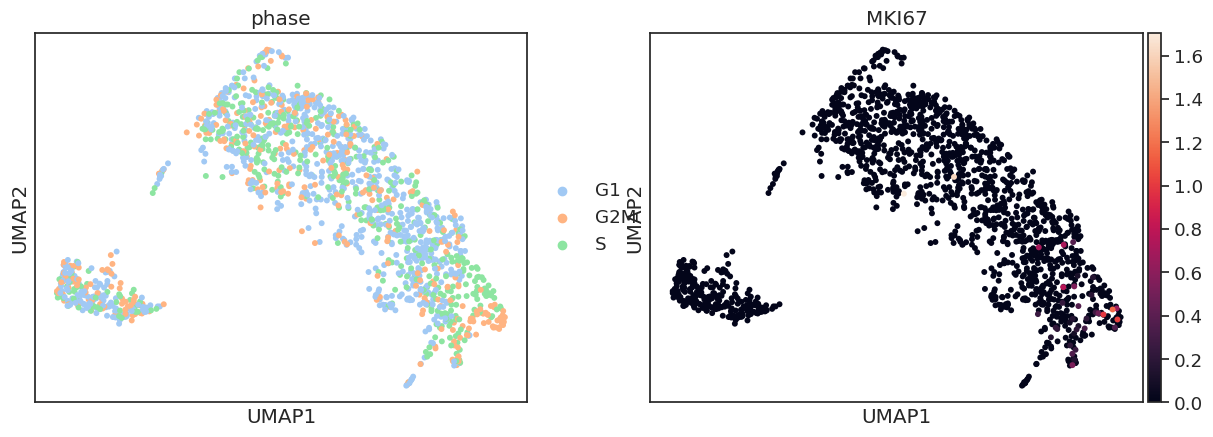

In [111]:
save_path='_rna_cellcycle.pdf'
sc.pl.umap(rna_core, color=['phase', 'MKI67'], save=save_path)

In [112]:
#sc.tl.dendrogram(rna_core, groupby='celltype_new_CNV_leiden',)
sc.tl.dendrogram(rna_core, groupby='celltype',)

In [113]:
adata_inf.obs['celltype'] = rna_core.obs['celltype']

In [114]:
adata_inf.obs['celltype']

AAACCGGCATCACAGC-1    Tumor Cells
AAACGCGCAACATAAG-1    Tumor Cells
AAACGCGCAAGCTTAT-1    Tumor Cells
AAACGCGCACCTAATG-1    Tumor Cells
AAACGTACACGTGCTG-1    Tumor Cells
                         ...     
TTTGTCTAGGAGCATA-1    Tumor Cells
TTTGTGAAGTTGTCAA-1    Tumor Cells
TTTGTGGCACTGGCCA-1    Tumor Cells
TTTGTGTTCGGTTTGG-1    Tumor Cells
TTTGTTGGTTGTTGCT-1    Tumor Cells
Name: celltype, Length: 1652, dtype: category
Categories (2, object): ['Tumor Cells', 'Immune Cells']

In [115]:
sc.tl.dendrogram(rna_core, groupby='celltype',)
sc.tl.rank_genes_groups(rna_core, groupby='celltype', method='wilcoxon')

result = rna_core.uns['rank_genes_groups']
gene_names=[]
gene_dict={}
for type in rna_core.obs['celltype'].unique():
    if type in result['names'].dtype.names:
        top_genes = result['names'][type][:10]
        gene_names.extend(top_genes)
        gene_dict[type]=top_genes
        
gene_dict


{'Tumor Cells': array(['PTPRZ1', 'NPAS3', 'NLGN1', 'LRP1B', 'NOVA1', 'PCDH9', 'DPP6',
        'LSAMP', 'MAGI2', 'PPP2R2B'], dtype=object),
 'Immune Cells': array(['DOCK4', 'PLXDC2', 'SLC11A1', 'LRMDA', 'SAT1', 'LDLRAD4',
        'ARHGAP24', 'MEF2A', 'FKBP5', 'SSH2'], dtype=object)}

In [116]:
GENEMARKERS = ['PLXDC2', 'SLC11A1','LRMDA', 'SAT1','LDLRAD4','PTPRZ1','NPAS3','NLGN1', 'LRP1B','NOVA1']


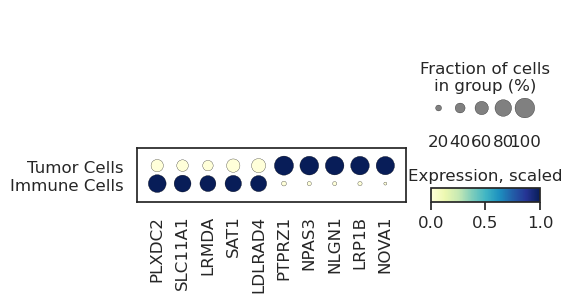

<Figure size 640x480 with 0 Axes>

In [119]:
sns.set_theme(style="white", palette="pastel", font_scale = 1.2, rc={"lines.linewidth": 0.5})
save_path='_rna_marker_genes.pdf'

sc.pl.dotplot(rna_core, var_names=GENEMARKERS, 
              groupby='celltype',colorbar_title='Expression, scaled',
              #categories_order=[ 'Brain neurons', 'mOli', 'Microglia'  ,'Astrocytes', 'Tumor cells' ], 
              standard_scale='var', 
              cmap='YlGnBu',  
              
              dendrogram=False,save=save_path)

# Save the figure
fig = plt.gcf()  # Capture current figure
fig.canvas.draw()  # Ensure canvas is updated
save_path_png = 'figures/BTROHT02-core_dotplot_annotated_plots.jpg'
save_path_pdf = 'figures/BTROHT02-core_dotplot_annotated_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')
fig.savefig(save_path_pdf, bbox_inches='tight')

# Display plot
plt.show()

## Save Final Version 

In [ ]:
BASE_DIR

In [120]:
# Save the file
rna_core.write(f'{BASE_DIR}/BTROHT02_5_core_rna_ANNOTATED_FINAL.h5ad')

## Reading RNA and ATAC data 

In [121]:
import scanpy as sc

import muon as mu

from muon import atac as ac
from muon import prot as pt

import scipy
import numpy as np 
import pandas as pd
 
from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd


In [123]:
rna_core = sc.read(f'{BASE_DIR}/BTROHT02_5_core_rna_ANNOTATED_FINAL.h5ad')

In [ ]:
rna_core

In [126]:
atac = sc.read(f'{BASE_DIR}/BTROHT02_1_core_raw_atac.h5ad')

In [127]:
atac

AnnData object with n_obs × n_vars = 1888 × 152566
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

## Reading RNA and ATAC DATA

## ATAC seq analysis¶

In [ ]:
#atac = mdata_core.mod['atac']
#atac

## QC for ATAC

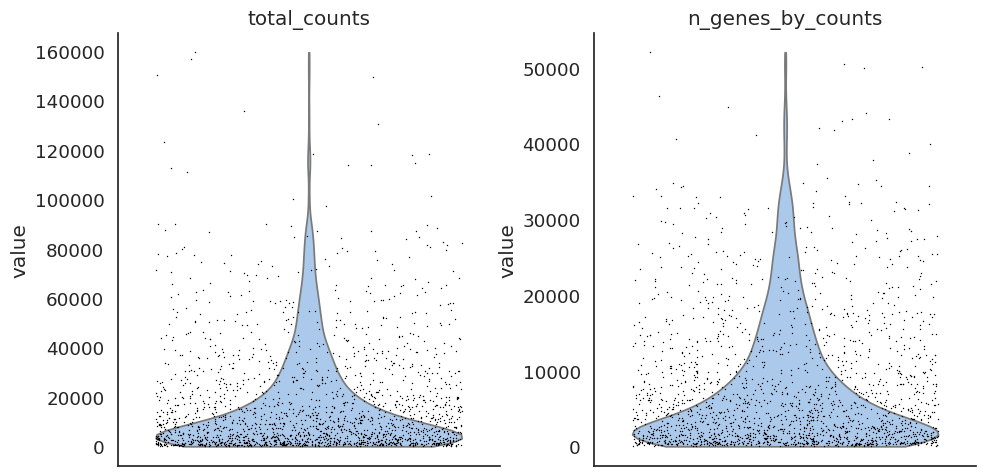

In [128]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

save_path = 'QC_ATAC_before_filtration.pdf'
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True, save=save_path)




## Nucleosome signal 

In [129]:
# Calculate the nucleosome signal across cells
# set n=10e3*atac.n_obs for rough estimate but faster run time
ac.tl.nucleosome_signal(atac, n=10e3 * atac.n_obs)

[W::hts_idx_load3] The index file is older than the data file: /group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/pre_demultiplexing/BTHROHT01_BTHROHT02_BTHROHT04/multiome/LAZ_315/atac_fragments.tsv.gz.tbi
Reading Fragments: 100%|██████████| 18880000/18880000 [00:42<00:00, 448638.30it/s]


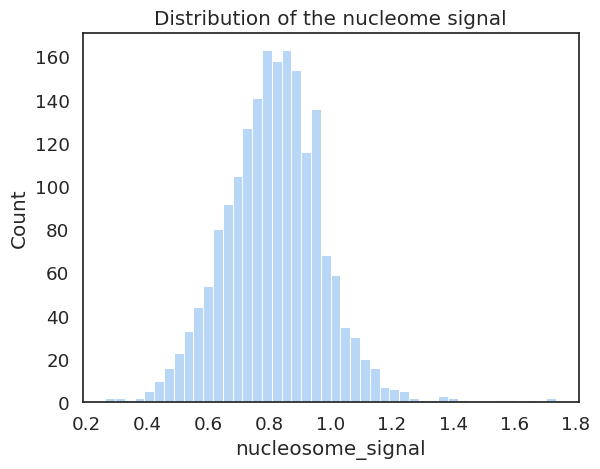

In [130]:
sns.histplot(atac.obs, x="nucleosome_signal")
plt.title("Distribution of the nucleome signal")
plt.show()

## Filtration 

In [131]:
mu.pp.filter_var(atac, "n_cells_by_counts", lambda x: x >= 5)

In [132]:
# mu.pp.filter_obs(
#     atac,
#     "tss_score",
#     lambda x: x >= 2,
# )
print(f"Number of cells after filtering on tss_score: {atac.n_obs}")
mu.pp.filter_obs(atac, "nucleosome_signal", lambda x: x <= 2)
print(f"Number of cells after filtering on nucleosome_signal: {atac.n_obs}")

Number of cells after filtering on tss_score: 1888
Number of cells after filtering on nucleosome_signal: 1888


In [133]:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 50000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

#mu.pp.filter_obs(
#    atac,
#    "total_counts",
#    lambda x: (x >= 500) & (x <= 150000), 
#)
print(f"Number of cells after filtering on n fragments: {atac.n_obs}")

Number of cells after filtering on n fragments: 1279


In [134]:
# Define the metrics
atac_metrics = {
    "atac_n_cells_by_counts": 5,
    "atac_n_genes_by_counts_bottom": 2000,
    "atac_n_genes_by_counts_top": 50000,
   # "atac_total_counts_top": 500,
   # "atac_total_counts_bottom": 150000,
}

# Define the file path
file_path = "QC_filtration_metrics.txt"

with open(file_path, 'a') as file:
    for key, value in atac_metrics.items():
        file.write(f"{key}: {value}\n")

print(f"Metrics have been written and appended to {file_path}")

Metrics have been written and appended to QC_filtration_metrics.txt


In [135]:
BASE_DIR

'/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core'

In [136]:
atac.write(f'{BASE_DIR}/BTROHT02_6_core_atac_QcFiltered.h5ad')

In [137]:
atac

AnnData object with n_obs × n_vars = 1279 × 152546
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

## SnapATAC and filtration¶

In [138]:
atac = sc.read(f'{BASE_DIR}/BTROHT02_6_core_atac_QcFiltered.h5ad')

In [139]:
import snapatac2 as snap
import numpy as np
import scanpy as sc

snap.__version__

'2.7.0'

In [140]:
#Choose barcodes from filtered data (filtered with muon)
valid_barcodes=atac.obs_names
len(valid_barcodes)

1279

In [141]:
BASE_DIR

'/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core'

In [144]:
%%time

data = snap.pp.import_data(
    f'{BASE_DIR}/Snap/atac_fragments.tsv',
    chrom_sizes=snap.genome.hg38,
    file=f'{BASE_DIR}/Snap/BTROHT_core_snap.h5ad',  # Optional
    sorted_by_barcode=False, whitelist=valid_barcodes,
    tempdir=f'{BASE_DIR}/Snap/tmpdir'
)
data

CPU times: user 8min 42s, sys: 25.1 s, total: 9min 7s
Wall time: 7min 41s


AnnData object with n_obs x n_vars = 1279 x 0 backed at '/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core/Snap/BTROHT_core_snap.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [145]:
data.close()

## Read Snap ATAC

In [146]:
data=snap.read(f'{BASE_DIR}/Snap/BTROHT_core_snap.h5ad', )
data

AnnData object with n_obs x n_vars = 1279 x 0 backed at '/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core/Snap/BTROHT_core_snap.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

## QC 

Computing fragment size distribution...


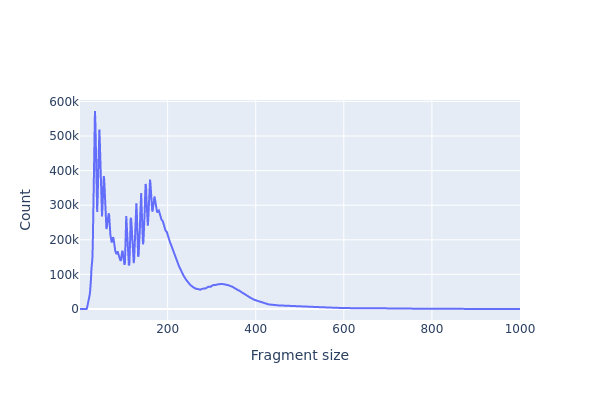

In [147]:
snap.pl.frag_size_distr(data, interactive=False, out_file='figures/QC_ATAC_frag_size_distr.pdf')

In [148]:
%%time
snap.metrics.tsse(data, snap.genome.hg38)

CPU times: user 39.7 s, sys: 2.56 s, total: 42.3 s
Wall time: 16.4 s


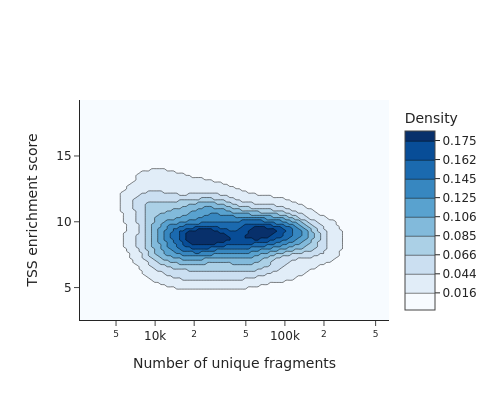

In [149]:
snap.pl.tsse(data, interactive=False, out_file='figures/QC_ATAC_tsse_frags.pdf')

In [150]:
data.obs['tsse'].min()

/tmp/ipykernel_3224031/1383754455.py:1: DeprecationWarning:

`Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'



4.190135284518608

In [151]:
data.obs['tsse'].mean()

/tmp/ipykernel_3224031/921509436.py:1: DeprecationWarning:

`Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'



9.038391772956615

In [152]:
## Add tile matrix, select features, remove doublets, 

In [153]:
%%time
snap.pp.add_tile_matrix(data) #add tile matrix with 500 bp window

CPU times: user 35.6 s, sys: 2.17 s, total: 37.7 s
Wall time: 27.4 s


In [154]:
snap.pp.select_features(data, n_features=25000) #feature selection to find the most variable

Selected 25000 features.


In [155]:
%%time
snap.pp.scrublet(data) #doublet identification

Simulating doublets...
Spectral embedding ...
Calculating doublet scores...


CPU times: user 15.1 s, sys: 795 ms, total: 15.9 s
Wall time: 15.5 s


In [156]:
snap.pp.filter_doublets(data) #doublet removal
data

Detected doublet rate = 4.457%


AnnData object with n_obs x n_vars = 1222 x 6062095 backed at '/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core/Snap/BTROHT_core_snap.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'library_tsse', 'frag_size_distr', 'frac_overlap_TSS', 'reference_sequences', 'TSS_profile', 'scrublet_sim_doublet_score', 'doublet_rate'
    obsm: 'fragment_paired'

In [157]:
data.write(f'{BASE_DIR}/Snap/BTROHT_core_snap_filtered.h5ad', )

In [158]:
data.close()

In [161]:
data = snap.read(f'{BASE_DIR}/Snap/BTROHT_core_snap_filtered.h5ad', )

In [162]:
data

AnnData object with n_obs x n_vars = 1222 x 6062095 backed at '/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core/Snap/BTROHT_core_snap_filtered.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'scrublet_sim_doublet_score', 'TSS_profile', 'frac_overlap_TSS', 'doublet_rate', 'frag_size_distr', 'library_tsse'
    obsm: 'fragment_paired'

## Reducing Dimentions

In [163]:
%%time
snap.tl.spectral(data, n_comps=40)

CPU times: user 6.28 s, sys: 672 ms, total: 6.95 s
Wall time: 7.74 s


In [164]:
%%time
snap.tl.umap(data, )

CPU times: user 5.76 s, sys: 26.8 ms, total: 5.79 s
Wall time: 5.68 s


In [165]:
%%time
snap.pp.knn(data)
snap.tl.leiden(data)

CPU times: user 111 ms, sys: 11.9 ms, total: 122 ms
Wall time: 393 ms


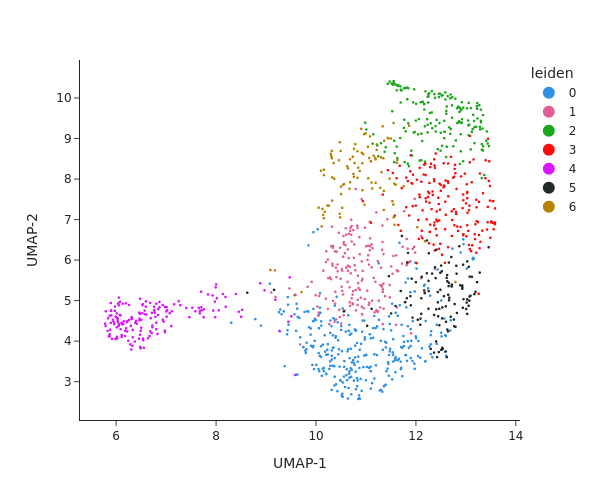

In [166]:
snap.pl.umap(data, color='leiden', interactive=False, height=500)

In [167]:
data.close()

In [168]:
data

Closed AnnData object

## Cluster Annotation

In [169]:
data = snap.read(f'{BASE_DIR}/Snap/BTROHT_core_snap_filtered.h5ad', )
data

AnnData object with n_obs x n_vars = 1222 x 6062095 backed at '/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core/Snap/BTROHT_core_snap_filtered.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'frac_overlap_TSS', 'frag_size_distr', 'library_tsse', 'reference_sequences', 'TSS_profile', 'scrublet_sim_doublet_score', 'spectral_eigenvalue', 'doublet_rate'
    obsm: 'X_spectral', 'fragment_paired', 'X_umap'
    obsp: 'distances'

In [170]:
%%time
gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.hg38, )
gene_matrix

CPU times: user 1min 24s, sys: 2.93 s, total: 1min 27s
Wall time: 33.9 s


AnnData object with n_obs × n_vars = 1222 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'

In [171]:
rna_core

AnnData object with n_obs × n_vars = 1652 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'kmeans_cluster', 'leiden', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex', 'predicted_labels', 'majority_voting', 'conf_score', 'celltypist_conf_score_Adult_Human_PrefrontalCortex', 'cnv_raw_l1', 'cnv_raw_l2', 'cnv_score', 'cnv_leiden', 'over_clustering', 'celltype', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex_colors', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex_colors', 'celltype_colors', 'cnv_leiden_colors', 'dendrogram_celltype', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'over_clust

In [172]:
# Initialize all values in gene_matrix.obs['annotation'] as None
gene_matrix.obs['celltype'] = None

# Update the annotation for cells that are present in both gene_matrix.obs and data.obs
common_cells = gene_matrix.obs.index.intersection(rna_core.obs.index)
gene_matrix.obs.loc[common_cells, 'celltype'] = rna_core.obs.loc[common_cells, 'celltype']


In [173]:
# Copy over UMAP embedding
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]

In [174]:
# Count occurrences of each type in the 'annotation' column
annotation_counts = gene_matrix.obs['celltype'].value_counts()

# Display the counts
print(annotation_counts)


celltype
Tumor Cells     1076
Immune Cells      87
Name: count, dtype: int64


... storing 'celltype' as categorical


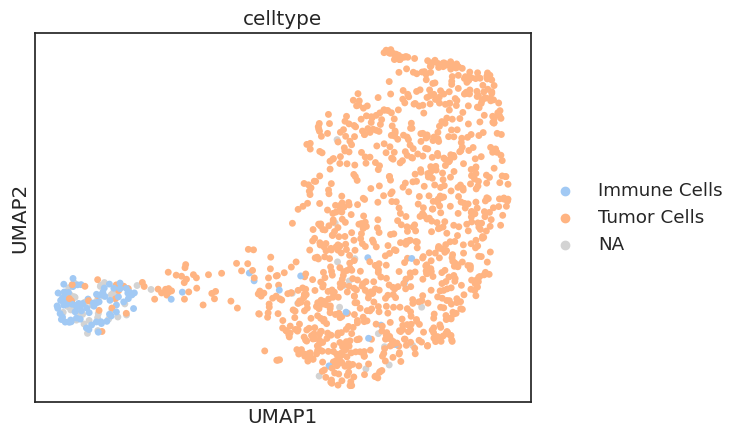

In [175]:
markers = ['celltype']
sc.pl.umap(gene_matrix, use_raw=False, color= markers , ncols=2)

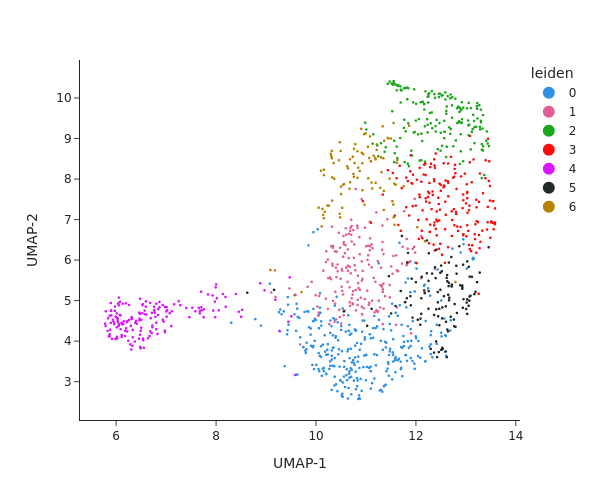

In [176]:
snap.pl.umap(data, color='leiden', interactive=False, height=500)

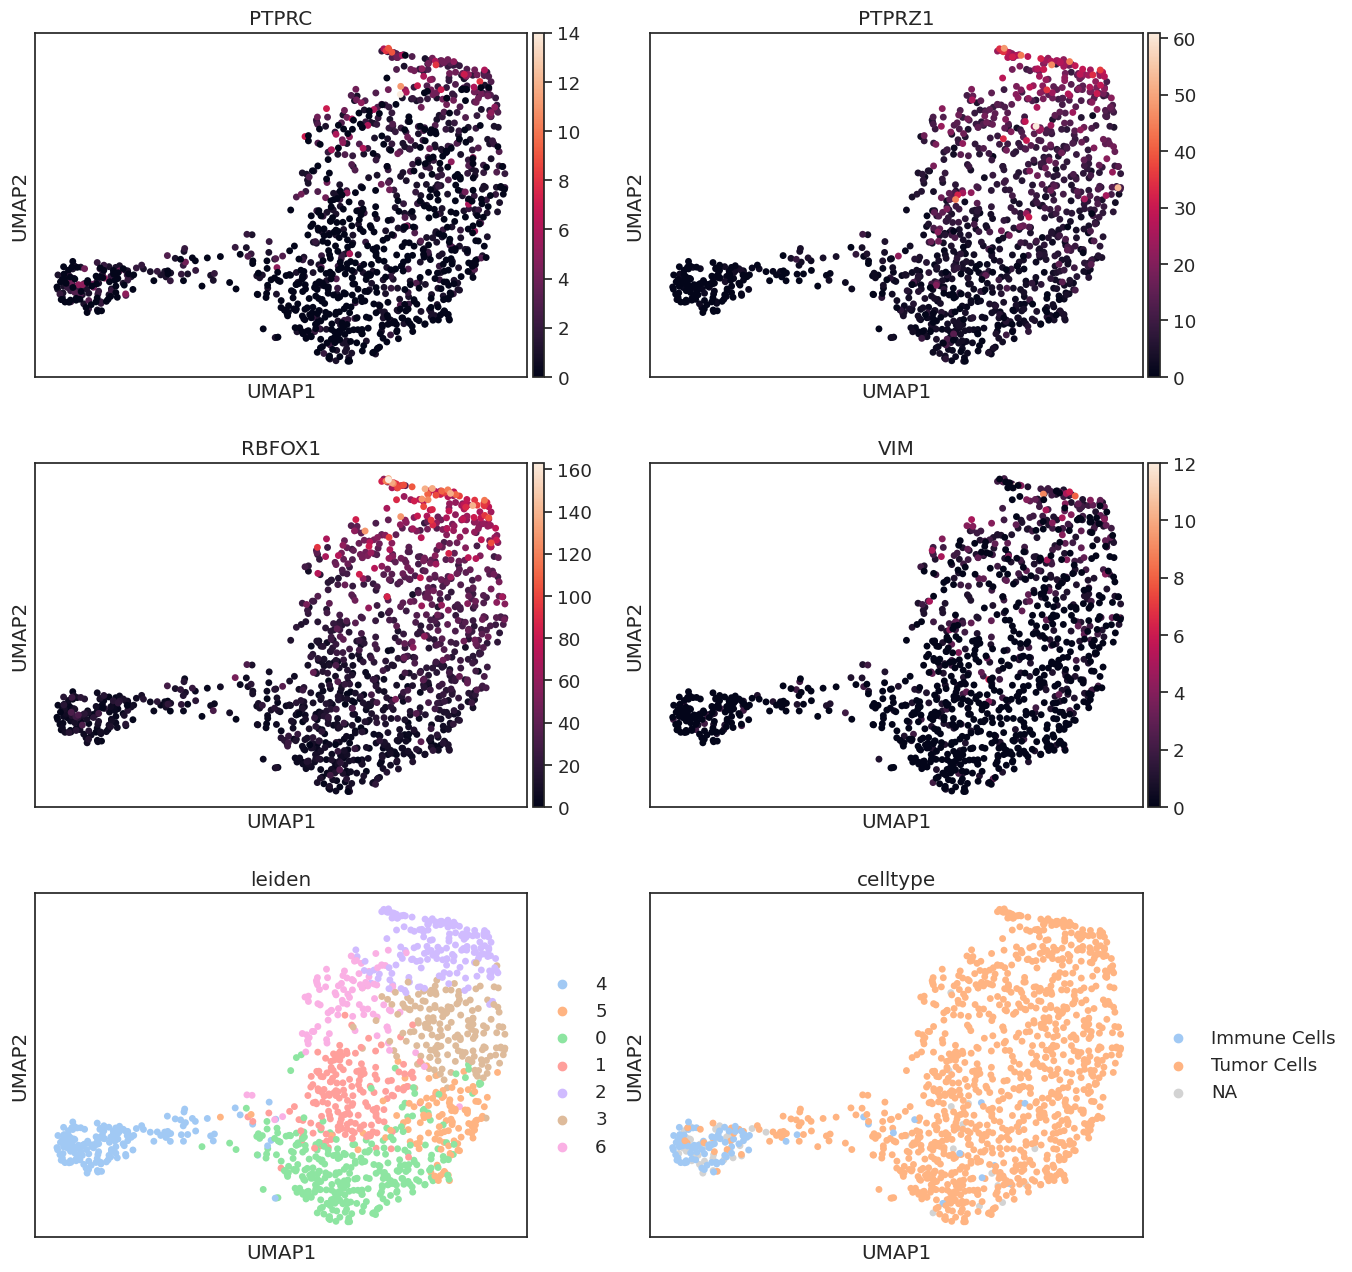

In [177]:
markers = ['PTPRC', 'PTPRZ1', 'RBFOX1','VIM', 'leiden','celltype']
sc.pl.umap(gene_matrix, use_raw=False, color= markers , ncols=2)

In [178]:
gene_matrix.obs['UMAP of ATAC in BTROH02-Core'] = gene_matrix.obs['celltype'] 

<Figure size 200x300 with 0 Axes>

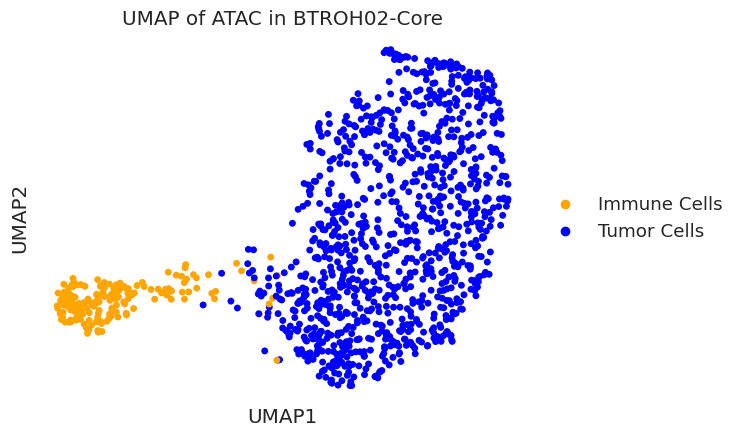

In [185]:
import os
import matplotlib.pyplot as plt
import scanpy as sc

# Assuming 'gene_matrix' is your AnnData object


# Define the markers you want to plot
markers = ['leiden', 'UMAP of ATAC in BTROH02-Core']

# Assign 'NA' cells based on 'leiden' clustering
na_cells = gene_matrix.obs['UMAP of ATAC in BTROH02-Core'].isna()
gene_matrix.obs.loc[na_cells & (gene_matrix.obs['leiden'] == '4'), 'UMAP of ATAC in BTROH02-Core'] = "Immune Cells"
gene_matrix.obs.loc[na_cells & (gene_matrix.obs['leiden'] != '4'), 'UMAP of ATAC in BTROH02-Core'] = "Tumor Cells"


# Define the markers and their corresponding colors
markers = ['UMAP of ATAC in BTROH02-Core']
color_map = {
    'Immune Cells': 'orange',
    'Tumor Cells': 'blue',
}

# Ensure the output directory exists
output_dir = 'figures'
os.makedirs(output_dir, exist_ok=True)

# Set figure size using matplotlib before plotting
plt.figure(figsize=(2, 3))

# Create a UMAP plot with specified colors
sc.pl.umap(
    gene_matrix,
    use_raw=False,
    color=markers,
    ncols=2,
    palette=color_map,
    show=False
)

# Remove the box around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Save the figure
fig = plt.gcf()  # Capture current figure
save_path_png = os.path.join(output_dir, 'core_atac_annotated_plots.jpg')
save_path_pdf = os.path.join(output_dir, 'core_atac_annotated_plots.pdf')
fig.savefig(save_path_png, bbox_inches='tight')
fig.savefig(save_path_pdf, bbox_inches='tight')

# Show the plot
plt.show()


In [186]:
gene_matrix

AnnData object with n_obs × n_vars = 1222 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype', 'UMAP of ATAC in BTROH04-Core', 'UMAP of ATAC in BTROH02-Core'
    uns: 'celltype_colors', 'leiden_colors', 'UMAP of ATAC in BTROH02-Core_colors'
    obsm: 'X_umap'

In [187]:
gene_matrix.write(f'{BASE_DIR}/BTROHT02_7_core_gene_matrix_ANNOTATED_FINAL.h5ad')

In [188]:
gene_matrix=sc.read(f'{BASE_DIR}/BTROHT02_7_core_gene_matrix_ANNOTATED_FINAL.h5ad')

In [189]:
gene_matrix

AnnData object with n_obs × n_vars = 1222 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype', 'UMAP of ATAC in BTROH04-Core', 'UMAP of ATAC in BTROH02-Core'
    uns: 'UMAP of ATAC in BTROH02-Core_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

In [190]:
rna_core

AnnData object with n_obs × n_vars = 1652 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'kmeans_cluster', 'leiden', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex', 'predicted_labels', 'majority_voting', 'conf_score', 'celltypist_conf_score_Adult_Human_PrefrontalCortex', 'cnv_raw_l1', 'cnv_raw_l2', 'cnv_score', 'cnv_leiden', 'over_clustering', 'celltype', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex_colors', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex_colors', 'celltype_colors', 'cnv_leiden_colors', 'dendrogram_celltype', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'over_clust

In [191]:
atac

AnnData object with n_obs × n_vars = 1279 × 152546
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

In [194]:
atac = sc.read(f'{BASE_DIR}/BTROHT02_6_core_atac_QcFiltered.h5ad')

## Normalization 

In [ ]:
#gff and gtf gene anno

In [195]:
atac= atac[list(set(gene_matrix.obs_names) & set(rna_core.obs_names)), :]
atac

View of AnnData object with n_obs × n_vars = 1163 × 152546
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

In [196]:
atac.layers["counts"] = atac.X

In [197]:
ac.pp.tfidf(atac, scale_factor=1e4)

In [198]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)

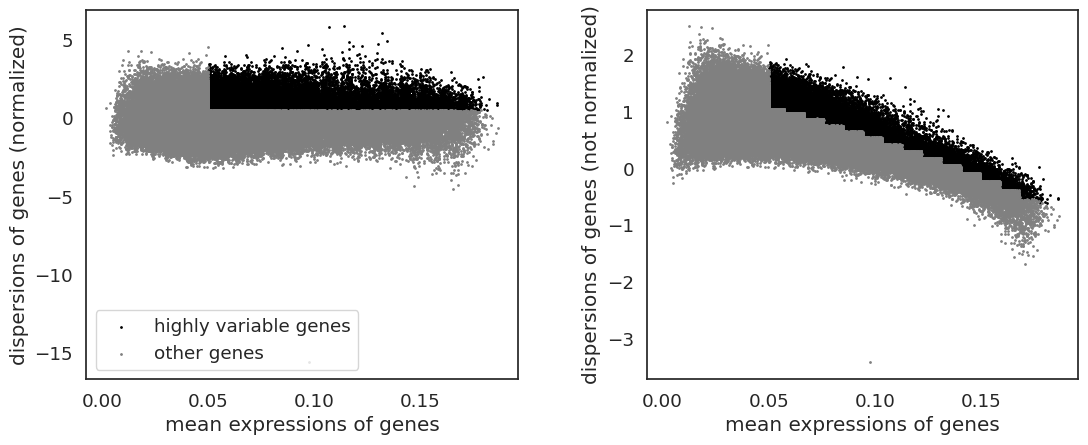

In [199]:
sc.pp.log1p(atac)
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)
sc.pl.highly_variable_genes(atac)
np.sum(atac.var.highly_variable)
atac.raw = atac

## LSI, gragh on LSI, PCA

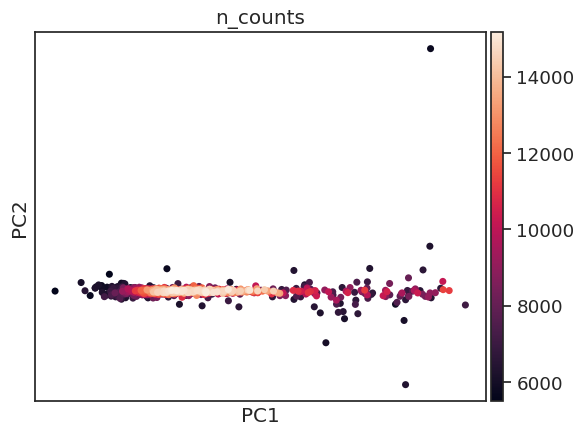

In [200]:
ac.tl.lsi(atac)
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:] #We find the first component is typically associated with number of peaks or counts per cell so it is reasonable to remove it
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.pp.scale(atac)
sc.tl.pca(atac)
sc.pl.pca(atac, color= ["n_counts"])


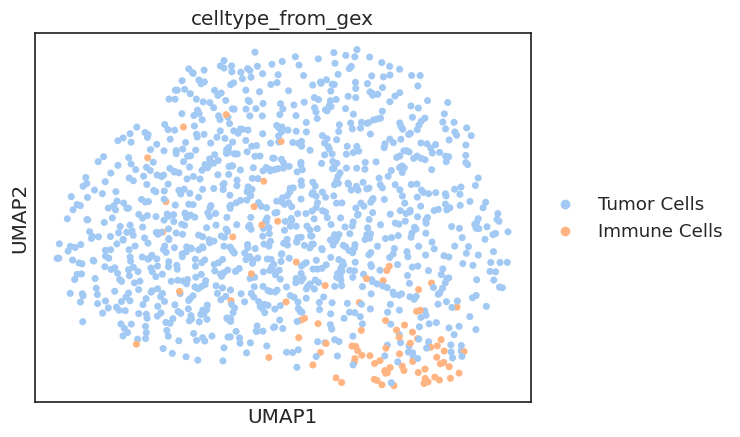

In [201]:
sc.tl.umap(atac)
atac.obs['celltype_from_gex']=rna_core.obs['celltype'].reindex(atac.obs_names)
sc.pl.umap(atac, color=["celltype_from_gex"])

## Graph on PCA 

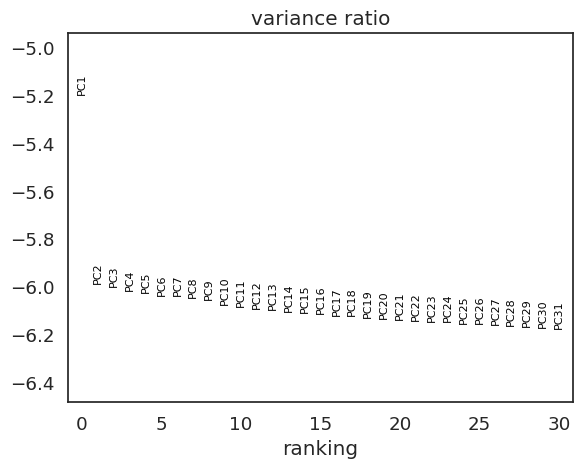

In [202]:
sc.pl.pca_variance_ratio(atac, log=True, )
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=20)
sc.tl.leiden(atac, resolution=.6)
sc.tl.umap(atac, spread=1, min_dist=.1, random_state=20)
#atac.obs['celltype_from_atac']=gene_matrix.obs['celltype_final'].reindex(atac.obs_names)
#atac.obs['celltype_from_gex']=rna.obs['celltype_with_tumor'].reindex(atac.obs_names)


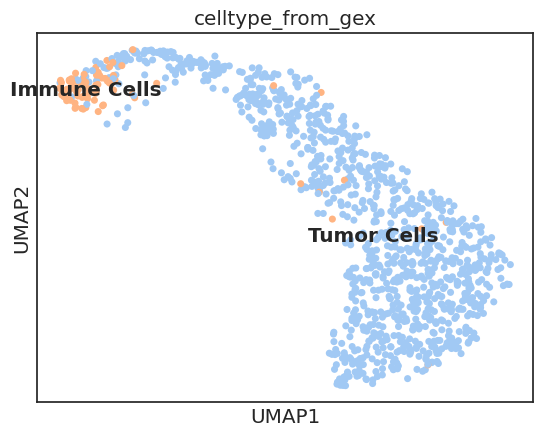

In [203]:
sc.pl.umap(atac, color=["celltype_from_gex"], legend_loc="on data")

In [204]:
atac.write(f'{BASE_DIR}/BTROHT02_8_core_atac_ANNOTATED_FINAL.h5ad')

In [ ]:
STOP

## for CONGAS 

## Barcode

In [11]:
!ls

'annotation for each sample 2 just core _ 1 of November .ipynb'
 BTROHT02_1_core_raw_atac.h5ad
 BTROHT02_2_core_raw_rna.h5ad
 BTROHT02_3_core_mdata_rna_atac.h5ad
 BTROHT02_4_core_rna_QcFiltered.h5ad
 BTROHT02_5_core_rna_ANNOTATED_FINAL.h5ad
 BTROHT02_6_core_atac_QcFiltered.h5ad
 BTROHT02_7_core_gene_matrix_ANNOTATED_FINAL.h5ad
 BTROHT02_8_core_atac_ANNOTATED_FINAL.h5ad
 CONGAS
 CORE_B2_27_NOV_ANNOTED_CONGAS.ipynb
 data
 figures
 QC_filtration_metrics.txt
 _rna_cnv_heatmap_celltypist.pdf
 _rna_cnv_heatmap_leiden.pdf
 Snap


In [12]:
BASE_DIR

'/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core'

In [10]:
gene_matrix=sc.read(f'{BASE_DIR}/BTROHT02_7_core_gene_matrix_ANNOTATED_FINAL.h5ad')

In [ ]:
gene_matrix.obs['UMAP of ATAC in BTROH02-Core'] = gene_matrix.obs['celltype'] 

In [11]:
gene_matrix

AnnData object with n_obs × n_vars = 1222 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype', 'UMAP of ATAC in BTROH04-Core', 'UMAP of ATAC in BTROH02-Core'
    uns: 'UMAP of ATAC in BTROH02-Core_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

In [15]:
gene_matrix.obs['UMAP of ATAC in BTROH02-Core'].value_counts()

UMAP of ATAC in BTROH02-Core
Tumor Cells     1053
Immune Cells     169
Name: count, dtype: int64

In [18]:
write_dataset(pd.DataFrame(gene_matrix.obs['UMAP of ATAC in BTROH02-Core']),
               f'{BASE_DIR}/CONGAS/BTROHT02_core_barcodes_all.tsv')

In [19]:
write_dataset(pd.DataFrame(gene_matrix.obs[gene_matrix.obs['UMAP of ATAC in BTROH02-Core'].isin(['UMAP of ATAC in BTROH02-Core'])]['UMAP of ATAC in BTROH02-Core']),
               f'{BASE_DIR}/CONGAS/BTROHT02_core_barcodes_tumorcells_.tsv')

## Segment file

In [ ]:
# seg file: /group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/BTROHT02/BTROHT02_T2/low_pass_wgs/ichorcna_1000kb/filter_none

In [1]:
segs = pd.read_csv('/group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/BTROHT02/BTROHT02_T2/low_pass_wgs/ichorcna_1000kb/filter_none/BTROHT02_T2.seg' , sep = '\t' )
segs 

NameError: name 'pd' is not defined

In [21]:
segs=segs[['chr', 'start', 'end', 'copy.number']]

In [22]:
segs=segs.rename(columns={'chr':'chr',
                          'start':'from', 
                          'end':'to', 
                          'copy.number':'copies'})
segs

chr      from         to  copies
0    1   1000001  248000000       2
1    2   1000001  242000000       2
2    3   1000001  198000000       2
3    4   2000001  189000000       2
4    5   1000001  181000000       2
5    6   1000001  170000000       2
6    7   1000001  159000000       4
7    8   1000001  145000000       2
8    9   1000001   36000000       1
9    9  36000001  138000000       2
10  10   1000001  133000000       1
11  11   1000001  135000000       2
12  12   1000001  132000000       2
13  13  20000001  113000000       1
14  14  20000001  105000000       2
15  15  25000001  101000000       2
16  16   1000001   90000000       2
17  17   1000001   83000000       2
18  18   1000001   80000000       2
19  19   1000001   45000000       2
20  19  45000001   54000000       1
21  19  55000001   58000000       2
22  20   1000001   64000000       2
23  21  14000001   46000000       3
24  22  19000001   49000000       1
25   X   4000001  154000000       1

In [23]:
segs['chr'] = 'chr' + segs['chr'].astype(str)
segs

chr      from         to  copies
0    chr1   1000001  248000000       2
1    chr2   1000001  242000000       2
2    chr3   1000001  198000000       2
3    chr4   2000001  189000000       2
4    chr5   1000001  181000000       2
5    chr6   1000001  170000000       2
6    chr7   1000001  159000000       4
7    chr8   1000001  145000000       2
8    chr9   1000001   36000000       1
9    chr9  36000001  138000000       2
10  chr10   1000001  133000000       1
11  chr11   1000001  135000000       2
12  chr12   1000001  132000000       2
13  chr13  20000001  113000000       1
14  chr14  20000001  105000000       2
15  chr15  25000001  101000000       2
16  chr16   1000001   90000000       2
17  chr17   1000001   83000000       2
18  chr18   1000001   80000000       2
19  chr19   1000001   45000000       2
20  chr19  45000001   54000000       1
21  chr19  55000001   58000000       2
22  chr20   1000001   64000000       2
23  chr21  14000001   46000000       3
24  chr22  19000001   49000000       1
25   chrX   4000001  154000000       1

In [24]:
write_dataset(segs,
               f'{BASE_DIR}/CONGAS/BTROHT02_copre_segs_for_congas.csv')

In [25]:
segs.loc[[6, 9, 13]]

chr      from         to  copies
6    chr7   1000001  159000000       4
9    chr9  36000001  138000000       2
13  chr13  20000001  113000000       1

In [26]:
write_dataset(segs.loc[[6, 9, 13]], f'{BASE_DIR}/CONGAS/BTROHT02_copre_segs_for_congas_chr7_chr10_chr14.csv')

In [ ]:
#END

# Cluster from CONGAS

In [10]:
gene_matrix=sc.read(f'{BASE_DIR}/BTROHT02_7_core_gene_matrix_ANNOTATED_FINAL.h5ad')

In [11]:
gene_matrix

AnnData object with n_obs × n_vars = 1222 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype', 'UMAP of ATAC in BTROH04-Core', 'UMAP of ATAC in BTROH02-Core'
    uns: 'UMAP of ATAC in BTROH02-Core_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

In [12]:
clusters_from_congas=pd.read_csv(f'{BASE_DIR}/CONGAS/BTROHT01_CONGAS_Clusters.csv', sep=',')
clusters_from_congas

cell cluster modality    multiome_barcode
0     AAACAGCCAGGCGAGT-1-ATAC      C2     ATAC  AAACAGCCAGGCGAGT-1
1     AAACCGGCATCACAGC-1-ATAC      C1     ATAC  AAACCGGCATCACAGC-1
2     AAACGCGCACCTAATG-1-ATAC      C2     ATAC  AAACGCGCACCTAATG-1
3     AAACGGATCGGGACCT-1-ATAC      C3     ATAC  AAACGGATCGGGACCT-1
4     AAACGTACACGTGCTG-1-ATAC      C1     ATAC  AAACGTACACGTGCTG-1
...                       ...     ...      ...                 ...
2439   TTTGGTAAGCTATGAC-1-RNA      C3      RNA  TTTGGTAAGCTATGAC-1
2440   TTTGTCTAGGAGCATA-1-RNA      C3      RNA  TTTGTCTAGGAGCATA-1
2441   TTTGTGAAGTTGTCAA-1-RNA      C1      RNA  TTTGTGAAGTTGTCAA-1
2442   TTTGTGTTCGGTTTGG-1-RNA      C3      RNA  TTTGTGTTCGGTTTGG-1
2443   TTTGTTGGTTGTTGCT-1-RNA      C3      RNA  TTTGTTGGTTGTTGCT-1

[2444 rows x 4 columns]

In [13]:
clusters_from_congas=clusters_from_congas[clusters_from_congas['modality']=='ATAC']
clusters_from_congas=clusters_from_congas.set_index('multiome_barcode')
clusters_from_congas

cell cluster modality
multiome_barcode                                            
AAACAGCCAGGCGAGT-1  AAACAGCCAGGCGAGT-1-ATAC      C2     ATAC
AAACCGGCATCACAGC-1  AAACCGGCATCACAGC-1-ATAC      C1     ATAC
AAACGCGCACCTAATG-1  AAACGCGCACCTAATG-1-ATAC      C2     ATAC
AAACGGATCGGGACCT-1  AAACGGATCGGGACCT-1-ATAC      C3     ATAC
AAACGTACACGTGCTG-1  AAACGTACACGTGCTG-1-ATAC      C1     ATAC
...                                     ...     ...      ...
TTTGGTAAGCTATGAC-1  TTTGGTAAGCTATGAC-1-ATAC      C3     ATAC
TTTGTCTAGGAGCATA-1  TTTGTCTAGGAGCATA-1-ATAC      C3     ATAC
TTTGTGAAGTTGTCAA-1  TTTGTGAAGTTGTCAA-1-ATAC      C1     ATAC
TTTGTGTTCGGTTTGG-1  TTTGTGTTCGGTTTGG-1-ATAC      C3     ATAC
TTTGTTGGTTGTTGCT-1  TTTGTTGGTTGTTGCT-1-ATAC      C3     ATAC

[1222 rows x 3 columns]

In [14]:
gene_matrix.obs['congas_cluster']=clusters_from_congas.reindex(gene_matrix.obs_names)['cluster']

In [15]:
gene_matrix

AnnData object with n_obs × n_vars = 1222 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype', 'UMAP of ATAC in BTROH04-Core', 'UMAP of ATAC in BTROH02-Core', 'congas_cluster'
    uns: 'UMAP of ATAC in BTROH02-Core_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

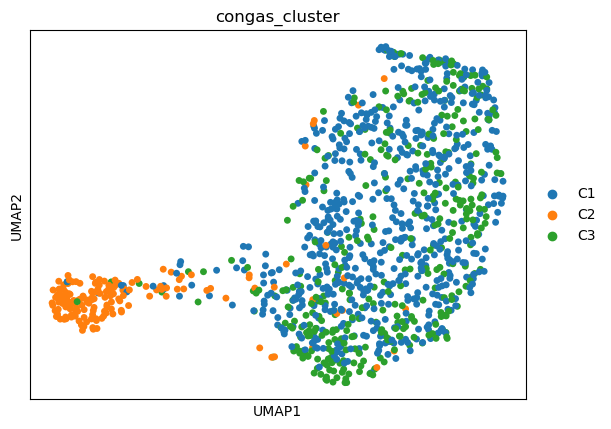

In [16]:
save_path='_ATAC_clusters_congas_all.pdf'
sc.pl.umap(gene_matrix, color=["congas_cluster"] , ncols=2, save=save_path)


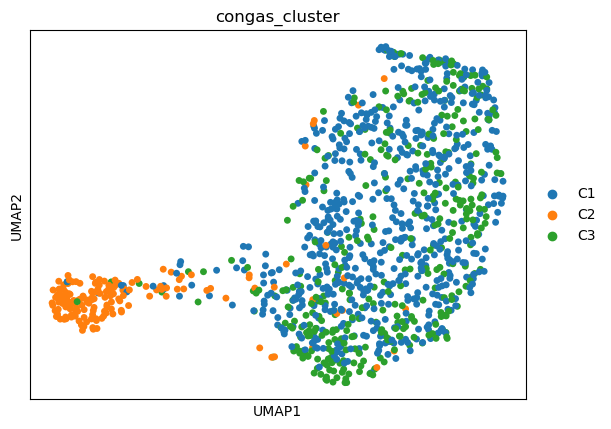

In [21]:
import matplotlib.pyplot as plt

# Step 1: Define the color mapping for clusters
cluster_to_color = {
    "C1": "#1f77b4",  # Blue for C1
    "C2": "#ff7f0e",  # Orange for C2
    "C3": "#2ca02c",  # Another shade of blue for C3
}

# Step 2: Map colors to cluster categories
cluster_colors = [cluster_to_color[cluster] for cluster in gene_matrix.obs["congas_cluster"].cat.categories]

# Step 3: Assign custom colors to the 'congas_cluster_colors' field
gene_matrix.uns['congas_cluster_colors'] = cluster_colors

# Step 4: Plot the UMAP
save_path = '_ATAC_clusters_congas_all.pdf'
sc.pl.umap(gene_matrix, color=["congas_cluster"], ncols=2, save=save_path)

# Optional: Show the plot (if running interactively)
plt.show()


Cluster categories: Index(['C1', 'C2', 'C3'], dtype='object')
Assigned colors: ['#1f77b4', '#ff7f0e', '#2ca02c']


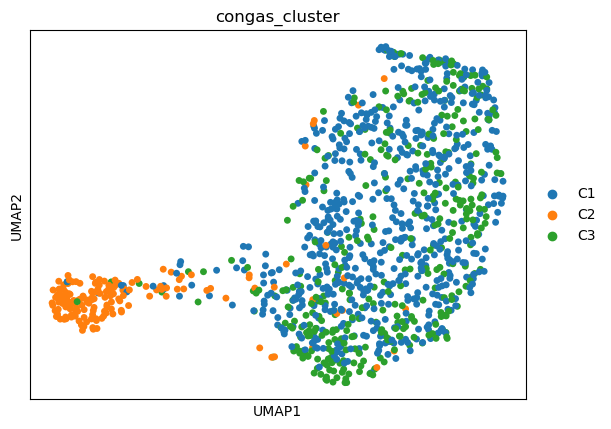

In [22]:
import matplotlib.pyplot as plt

# Step 1: Define the color mapping for each cluster
cluster_to_color = {
    "C1": "#1f77b4",  # Blue for C1
    "C2": "#ff7f0e",  # Orange for C2
    "C3": "#2ca02c",  # Green for C3
}

# Step 2: Ensure that the cluster column is categorical
gene_matrix.obs["congas_cluster"] = gene_matrix.obs["congas_cluster"].astype('category')

# Step 3: Assign custom colors to the 'congas_cluster' categories
# This will make sure that each cluster gets its correct color
gene_matrix.uns['congas_cluster_colors'] = [cluster_to_color[cluster] for cluster in gene_matrix.obs["congas_cluster"].cat.categories]

# Step 4: Verify that the colors are assigned correctly
print("Cluster categories:", gene_matrix.obs["congas_cluster"].cat.categories)
print("Assigned colors:", gene_matrix.uns['congas_cluster_colors'])

# Step 5: Plot the UMAP and save it
save_path = '_ATAC_clusters_congas_all.pdf'
sc.pl.umap(gene_matrix, color=["congas_cluster"], ncols=2, save=save_path)

# Optional: Display the plot interactively (if running in a Jupyter notebook)
plt.show()


Cluster categories: Index(['C1', 'C2', 'C3'], dtype='object')
Assigned colors: ['#1f77b4', '#ff7f0e', '#2ca02c']


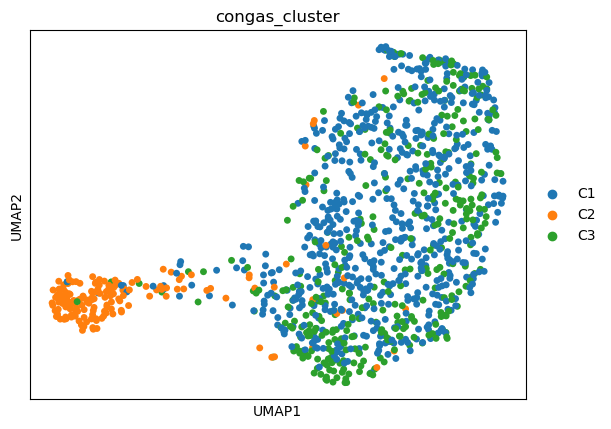

In [23]:
import matplotlib.pyplot as plt
import scanpy as sc

# Step 1: Define the color mapping for each cluster
cluster_to_color = {
    "C1": "#1f77b4",  # Blue for C1
    "C2": "#ff7f0e",  # Orange for C2
    "C3": "#2ca02c",  # Green for C3
}

# Step 2: Ensure that the cluster column is categorical
gene_matrix.obs["congas_cluster"] = gene_matrix.obs["congas_cluster"].astype('category')

# Step 3: Assign custom colors to the 'congas_cluster' categories
# This step makes sure the color mapping is applied to the 'congas_cluster'
gene_matrix.uns['congas_cluster_colors'] = [cluster_to_color[cluster] for cluster in gene_matrix.obs["congas_cluster"].cat.categories]

# Step 4: Verify that the colors are assigned correctly
print("Cluster categories:", gene_matrix.obs["congas_cluster"].cat.categories)
print("Assigned colors:", gene_matrix.uns['congas_cluster_colors'])

# Step 5: Plot the UMAP and save it, applying the color map
save_path = '_ATAC_clusters_congas_all.pdf'
sc.pl.umap(gene_matrix, color=["congas_cluster"], ncols=2, palette=cluster_to_color, save=save_path)

# Optional: Display the plot interactively (if running in a Jupyter notebook)
plt.show()


In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

# Assuming `rna_core` is your AnnData object
# Define the color mapping for tumor and immune cells
colors = ['blue' if 'C1' in cell_type.lower() else 'orange' if 'C2' in cell_type.lower() else 'gray' 
          for cell_type in rna_core.obs['celltype'].unique()]

# Create a color mapping dictionary to associate cell types with their respective colors
color_mapping = dict(zip(rna_core.obs['celltype'].unique(), colors))

# Create the UMAP plot
fig, ax = plt.subplots(figsize=(8, 5))  # Adjust the figsize as needed
sc.pl.umap(
    rna_core, 
    color='celltype', 
    vmax=20000, 
    palette=color_mapping,
    title='UMAP of Gene Expression in BTROHT02-Core',
    show=False,  # Avoid automatic display with a box around
    ax=ax
)


# Adjust layout to remove the box
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.axis('off')  # Hide the axis to avoid a box around the plot


# Save the figure
save_path_png = 'figures/UMAP_BTROHT02-core_leiden_annotated_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT02-core_leiden_annotated_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box



# Display the plot
plt.show()

In [29]:
gene_matrix.obs['congas_cluster']

AAACAGCCAGGCGAGT-1    C2
AAACCGGCATCACAGC-1    C1
AAACGCGCACCTAATG-1    C2
AAACGGATCGGGACCT-1    C3
AAACGTACACGTGCTG-1    C1
                      ..
TTTGGTAAGCTATGAC-1    C3
TTTGTCTAGGAGCATA-1    C3
TTTGTGAAGTTGTCAA-1    C1
TTTGTGTTCGGTTTGG-1    C3
TTTGTTGGTTGTTGCT-1    C3
Name: congas_cluster, Length: 1222, dtype: category
Categories (3, object): ['C1', 'C2', 'C3']

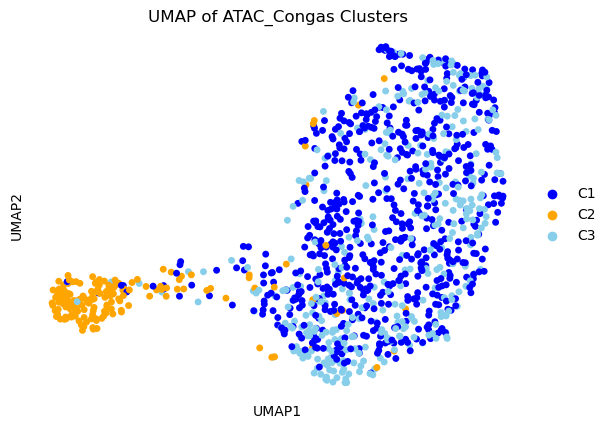

In [44]:
import matplotlib.pyplot as plt

color_mapping = {
    "C1": "blue",  # Blue for C1
    "C2": "orange",  # Orange for C2
    "C3": "#87CEEB",  # Light blue for C3
}

# Generate the UMAP plot
ax = sc.pl.umap(
    gene_matrix, 
    color='congas_cluster',  # Use the 'congas_cluster' column for coloring
    title='UMAP of ATAC_Congas Clusters',
    show=False,  # Avoid automatic display with a box around
    palette=color_mapping
)

# Remove the lines (spines) around the plot
for spine in ax.spines.values():
    spine.set_visible(False)

# Save the figure
save_path_png = 'figures/UMAP_BTROHT02-core_congas_clusters_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT02-core_congas_clusters_plots.pdf'

# Save as PNG and PDF with tight bounding box
ax.figure.savefig(save_path_png, bbox_inches='tight')
ax.figure.savefig(save_path_pdf, bbox_inches='tight')

# Display the plot
plt.show()
